### Challenge

#### Problem Description
You are presented with a dataset `train_data.csv` that contains the daily sales for more than 1000 stores of a chain. In addition, we provide the dataset `store.csv` that contains details for each store.

#### Your Task
Your task is to build a model that predicts the daily sales for the test data set

In [2]:
import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import lightgbm as lgb
from tqdm.notebook import tqdm

import sklearn
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import f_oneway

import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="darkgrid")

Lets start by look at the data (`train.csv`)

### Train Data

In [3]:
train_df = pd.read_csv("./data/train.csv", low_memory=False, parse_dates=["Date"])

In [4]:
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
train_df.shape

(1017209, 9)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


So from above columns, there's a couple of big indices (aggregation levels):
- Store
- Assortment
- Day of the Week
- Date

Target variable:
- `Sales`

Impactful variables:
- `Promo`
- `StateHoliday`
- `SchoolHoliday`

The other variables, the promo-related ones, should theoritically have a significant impact on sales. A store under a Promo period must have higher sales, but can also be the case that stores that are under a period of sales, because of other factors, do not have the same impact and can be dangerous from a company perspective. 

My idea is to besides fulfilling all the challenges objectives (meaning having the predictions as in the Kaggle challenge) I also did a very basic causality exercise. My hypothesis `Sales` can be optimized (maximized) if certain promotions in certain segments of products (`Assortments`) are launched in specific days and holidays. The work in this challenge should be seen as a proof of potential to invest more time into this problem. The ultimate goal would be to automate promotions and eventually stocks. This system would use the modelling approach but would require an optimization system that can be basic as follows:

1. Generate predictions on tuples : ```[Store, Assortment, DayofWeek, Date, Promo, StateHoliday, ...]``` with different values, simulating as much hypothesis as feasible
2. From each and all candidate tuples ```[Store, Assortment, DayofWeek, Date, Promo, StateHoliday, ...]``` select the one that generates more sales
3. Expose results through an API/PostgreSQL

Another note about this dataset is that comes from Rossamann, a household name and Germany. Because its indeed in Germany, there are other factors, like Day of the Week that can have a significant impact not only to obvious customer/industry patters, but because most Rossmann stores are closed on Sundays. One question that immediately comes to mind is if its worth it to do promo on Rossmann stores that are (the few) stores opened during that day.  

In [7]:
train_df.Store.nunique()

1115

In [180]:
# temporal features
train_df["Week"] = train_df["Date"].dt.week
train_df["Month"] = train_df["Date"].dt.month
train_df['Year']= train_df["Date"].dt.year
train_df['Day']= train_df["Date"].dt.strftime('%A')

#the average purchase basket
train_df['SalesperCustomer']=train_df['Sales']/train_df['Customers']

In [181]:
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             4   
1      2          5 2015-07-31   6064        625     1      1             4   
2      3          5 2015-07-31   8314        821     1      1             4   
3      4          5 2015-07-31  13995       1498     1      1             4   
4      5          5 2015-07-31   4822        559     1      1             4   

   SchoolHoliday  Week  Month  Year     Day  SalesperCustomer  EndOfMonth  \
0              1    31      7  2015  Friday          9.482883         1.0   
1              1    31      7  2015  Friday          9.702400         1.0   
2              1    31      7  2015  Friday         10.126675         1.0   
3              1    31      7  2015  Friday          9.342457         1.0   
4              1    31      7  2015  Friday          8.626118         1.0   

   BeginningOfMonth  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [182]:
sales = train_df.groupby(by='Date').agg({'Sales': 'sum'}).reset_index()
fig = px.line(sales, x="Date", y="Sales", title="Daily Sales")
fig.show()

 ## Feature Engineering 

#### End Month / Begin Month

In [11]:
def get_end_month(day_of_month):
    return (day_of_month/31)**4

def get_beginning_month(day_of_month):
    return ((31-day_of_month)/31)**4

train_df['EndOfMonth'] = train_df["Date"].dt.day.apply(get_end_month)
train_df['BeginningOfMonth'] = train_df["Date"].dt.day.apply(get_beginning_month)

In [12]:
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  Week  Month  Year     Day  SalesperCustomer  EndOfMonth  \
0              1    31      7  2015  Friday          9.482883         1.0   
1              1    31      7  2015  Friday          9.702400         1.0   
2              1    31      7  2015  Friday         10.126675         1.0   
3              1    31      7  2015  Friday          9.342457         1.0   
4              1    31      7  2015  Friday          8.626118         1.0   

   BeginningOfMonth  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [13]:
month_features = train_df.groupby(by='Date').agg({'EndOfMonth': 'first', 
                                                  'BeginningOfMonth': 'first'}).reset_index()

In [14]:
month_features.head()

Date  EndOfMonth  BeginningOfMonth
0 2013-01-01    0.000001          0.877078
1 2013-01-02    0.000017          0.765853
2 2013-01-03    0.000088          0.665557
3 2013-01-04    0.000277          0.575451
4 2013-01-05    0.000677          0.494819

In [15]:
fig = px.line(month_features, x="Date", y="EndOfMonth")
fig.update_traces(line_color='red')

fig2 = px.line(month_features, x="Date", y="BeginningOfMonth")
fig3 = go.Figure(data=fig.data + fig2.data)
fig3.update_layout(
    title=dict(text="EndOfMonth/BeginningOfMonth pattern")
)
fig3.show()

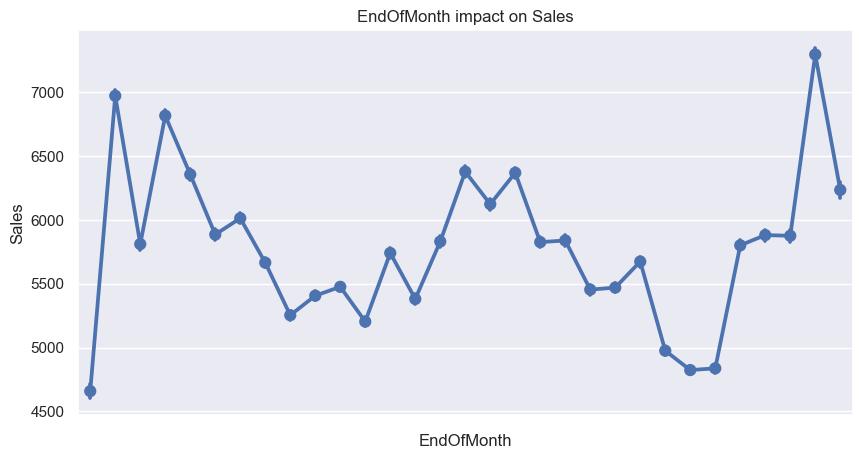

In [16]:
fig = plt.subplots(figsize=(10,5))   

g = sns.pointplot(x='EndOfMonth',y='Sales',data=train_df)
g.set(xticklabels=[])
g.set(title='EndOfMonth impact on Sales')
plt.show()

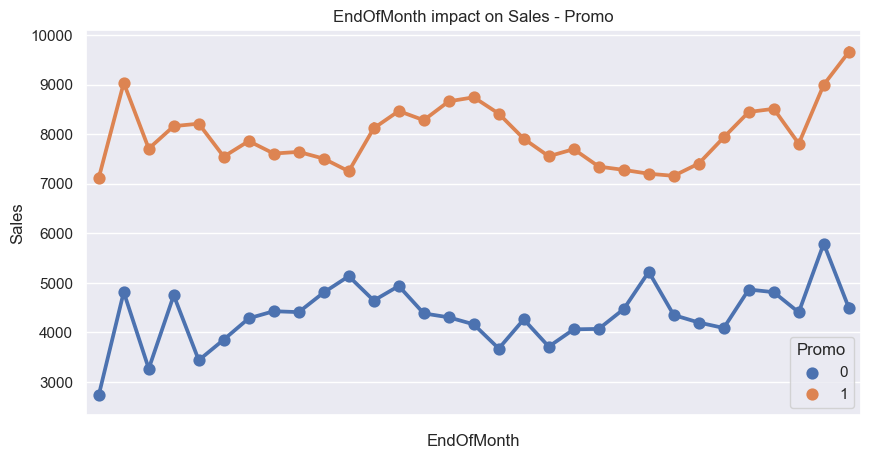

In [17]:
fig = plt.subplots(figsize=(10,5))   

g = sns.pointplot(x='EndOfMonth',y='Sales',hue='Promo',data=train_df)
g.set(xticklabels=[])
g.set(title='EndOfMonth impact on Sales - Promo')
plt.show()

As we can see, there is a substantial difference between `EndOfMonth` with Promo/NoPromo. This is really interesting, and makes the point of having 2 different models instead of 1. This is the most simple causality approach.

The training loop is described as follows:

![alternative text](img/training.png)


The prediction loop is as follows:

![alternative text](img/predict_uplift.png)



In [18]:
train_df.Promo.value_counts()

0    629129
1    388080
Name: Promo, dtype: int64

#### `StateHoliday` enconding

In [19]:
train_df.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [20]:
train_df["StateHoliday"] = train_df["StateHoliday"].replace(to_replace='0', value='d')
train_df["StateHoliday"].replace({'a':1, 'b':2, 'c':3, 'd':4}, inplace = True)

In [21]:
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             4   
1      2          5 2015-07-31   6064        625     1      1             4   
2      3          5 2015-07-31   8314        821     1      1             4   
3      4          5 2015-07-31  13995       1498     1      1             4   
4      5          5 2015-07-31   4822        559     1      1             4   

   SchoolHoliday  Week  Month  Year     Day  SalesperCustomer  EndOfMonth  \
0              1    31      7  2015  Friday          9.482883         1.0   
1              1    31      7  2015  Friday          9.702400         1.0   
2              1    31      7  2015  Friday         10.126675         1.0   
3              1    31      7  2015  Friday          9.342457         1.0   
4              1    31      7  2015  Friday          8.626118         1.0   

   BeginningOfMonth  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

## Open/Close note

Given that sales are 0 if the store is closed we assume that this scenario is truth no matter what.

In [22]:
train_df[(train_df.Open == 0) & (train_df.Sales == 0)].shape

(172817, 16)

172817 closed stores in the data (around 16%) - To avoid any biased predictions we will drop these values

In [23]:
train_df[(train_df.Open == 0) & (train_df.Sales == 0)].shape[0] / train_df.shape[0]

0.16989330609540418

In [24]:
train_df[(train_df.Sales == 0)].shape

(172871, 16)

Stores that have non-zero sales are `Open`

In [25]:
train_df[(train_df.Open == 1) & (train_df.Sales == 0)].shape

(54, 16)

In [26]:
train_df[(train_df["Sales"] > 0)].shape

(844338, 16)

In [27]:
train_df_pre = train_df[(train_df["Sales"] > 0)]

We don't have `Customer` column on the test set!

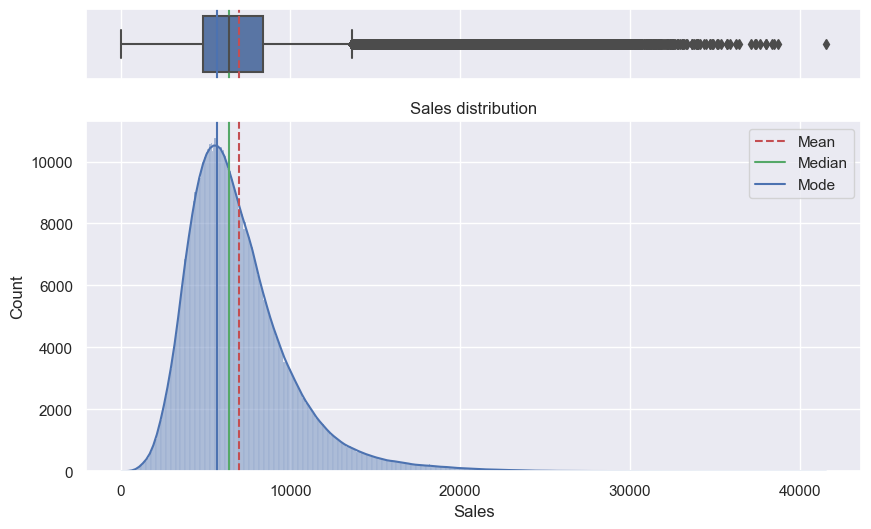

In [28]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)}, figsize=(10,6))   

mean = train_df_pre["Sales"].mean()
median = train_df_pre["Sales"].median()
mode = train_df_pre["Sales"].mode().values[0]

sns.boxplot(data=train_df_pre, x="Sales", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=train_df_pre, x="Sales", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")

ax_hist.legend()

ax_box.set(xlabel='')
plt.title("Sales distribution")
plt.show()

### Store Data

In [29]:
store_df = pd.read_csv("./data/store.csv", low_memory=False)

In [30]:
store_df.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [31]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


<Axes: >

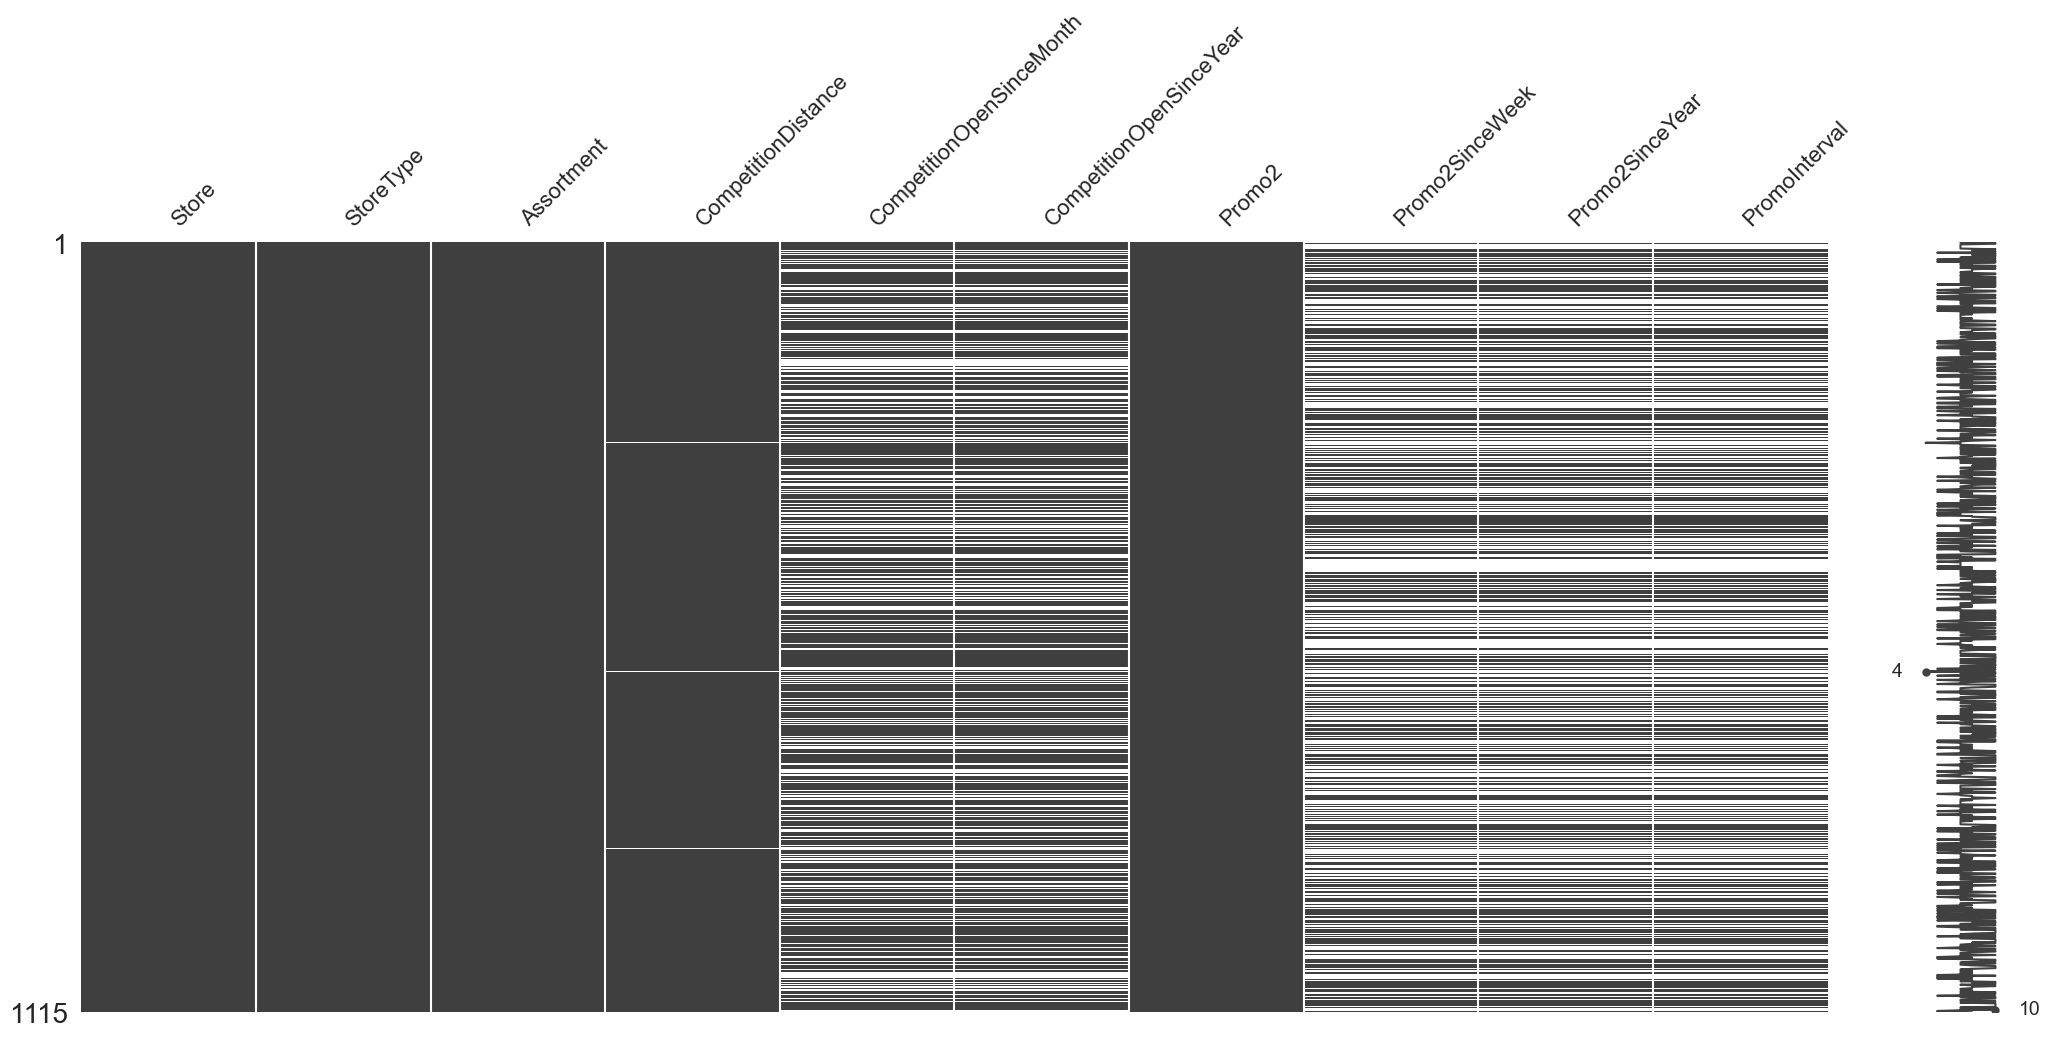

In [32]:
msno.matrix(store_df)

#### Missing Values

Another interesting aspect is that `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear` are correlated, so we assign -1 to this feature.

In [33]:
store_df[store_df.CompetitionDistance.isna()]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

#### `CompetitionDistance`

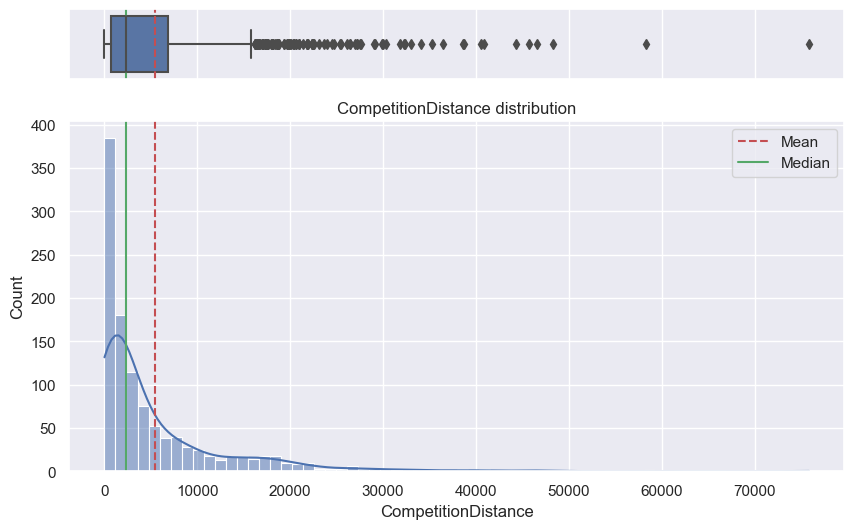

In [134]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)}, figsize=(10,6))   
mean = store_df["CompetitionDistance"].mean()
median = store_df["CompetitionDistance"].median()

sns.boxplot(data=store_df, x="CompetitionDistance", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.histplot(data=store_df, x="CompetitionDistance", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")

ax_hist.legend()

ax_box.set(xlabel='')
plt.title("CompetitionDistance distribution")
plt.show()

Fill with `mean`or 0? or -1?

In [35]:
store_df['CompetitionDistance'] = store_df['CompetitionDistance'].fillna(
        store_df['CompetitionDistance'].mean()
)

In [36]:
store_df.groupby(['StoreType','Assortment']).Assortment.count()

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Assortment, dtype: int64

#### Merging the store meta-data with sales...

In [37]:
train_store = pd.merge(left = train_df_pre, right = store_df, how='left', on=['Store'])

In [38]:
train_store.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             4   
1      2          5 2015-07-31   6064        625     1      1             4   
2      3          5 2015-07-31   8314        821     1      1             4   
3      4          5 2015-07-31  13995       1498     1      1             4   
4      5          5 2015-07-31   4822        559     1      1             4   

   SchoolHoliday  Week  ...  BeginningOfMonth  StoreType Assortment  \
0              1    31  ...               0.0          c          a   
1              1    31  ...               0.0          a          a   
2              1    31  ...               0.0          a          a   
3              1    31  ...               0.0          c          c   
4              1    31  ...               0.0          a          a   

   CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                        9.0                    2008.0   
1                570.0                       11.0                    2007.0   
2              14130.0                       12.0                    2006.0   
3                620.0                        9.0                    2009.0   
4              29910.0                        4.0                    2015.0   

  Promo2 Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0      0             NaN              NaN              NaN  
1      1            13.0           2010.0  Jan,Apr,Jul,Oct  
2      1            14.0           2011.0  Jan,Apr,Jul,Oct  
3      0             NaN              NaN              NaN  
4      0             NaN              NaN              NaN  

[5 rows x 25 columns]

In [39]:
train_store.groupby(['StoreType']).Sales.sum()

StoreType
a    3165334859
b     159231395
c     783221426
d    1765392943
Name: Sales, dtype: int64

In [40]:
train_store.groupby(['StoreType']).Sales.sum() / train_store.Sales.sum()

StoreType
a    0.538947
b    0.027112
c    0.133356
d    0.300586
Name: Sales, dtype: float64

**Store Types `a` and `d` are the most numerous and account for more than 80% of total sales**

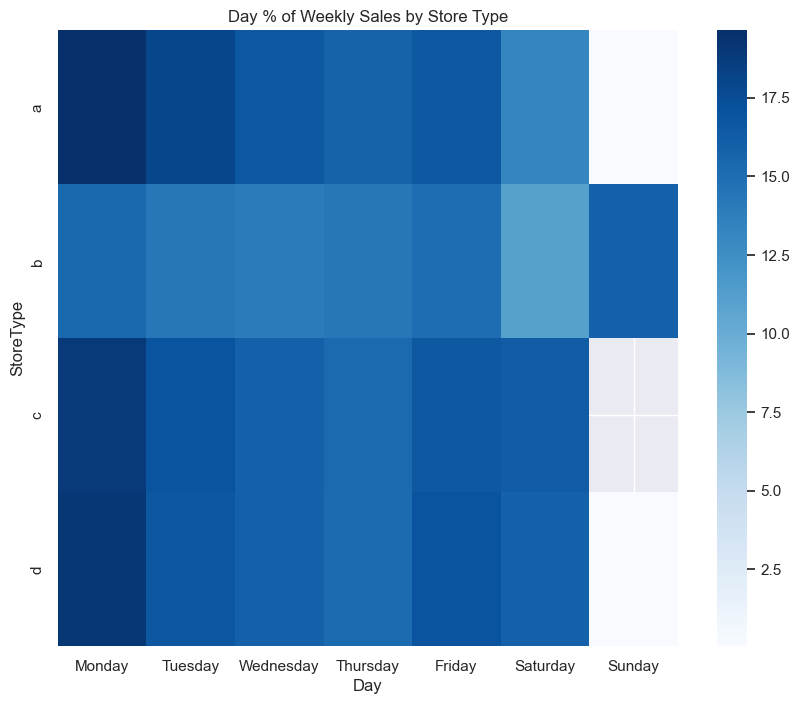

In [41]:
store_open=train_store[(train_store.Open==1)]

saledaystype=store_open.groupby(['StoreType','Day']).sum()['Sales'].groupby(level=0).apply(lambda x:100*x/x.sum()).unstack().loc[:,[
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday']]
fig = plt.subplots(figsize=(10,8))   
g = sns.heatmap(saledaystype,cmap='Blues').set_title('Day % of Weekly Sales by Store Type')

Stores are typically closed on Sundays. Of all the four store types, only Store Type `b` opens on Sundays. Store Type `b`, while relatively few in number, plug an important market place gap - cater to Sunday shoppers. Store Type `b` customers tend to have the smallest average purchase basket relative to those at the other store types. But customer volume is highest for Store Type `b` as it operates 7 days a week.

## `Promo`

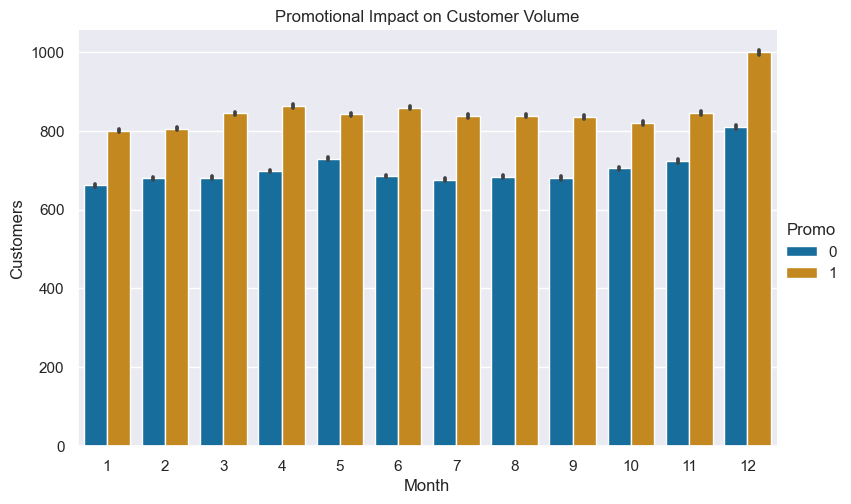

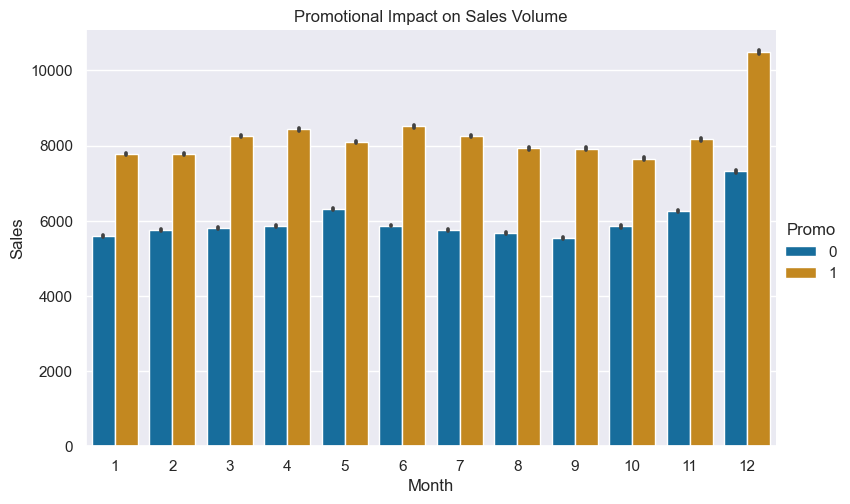

In [42]:
sns.catplot(data=store_open,x='Month',y='Customers',palette='colorblind',hue='Promo',kind='bar',height=5,
           aspect=8/5)
plt.title('Promotional Impact on Customer Volume')

sns.catplot(data=store_open, x='Month',y='Sales',palette='colorblind',hue='Promo',kind='bar',height=5,
           aspect=8/5)

plt.title('Promotional Impact on Sales Volume')
plt.show()

Overall, promotional events provide lift to both customer and sales volume. 
The impact is most noticeable during the month of December which is when consumers shop for Christmas and New Year.

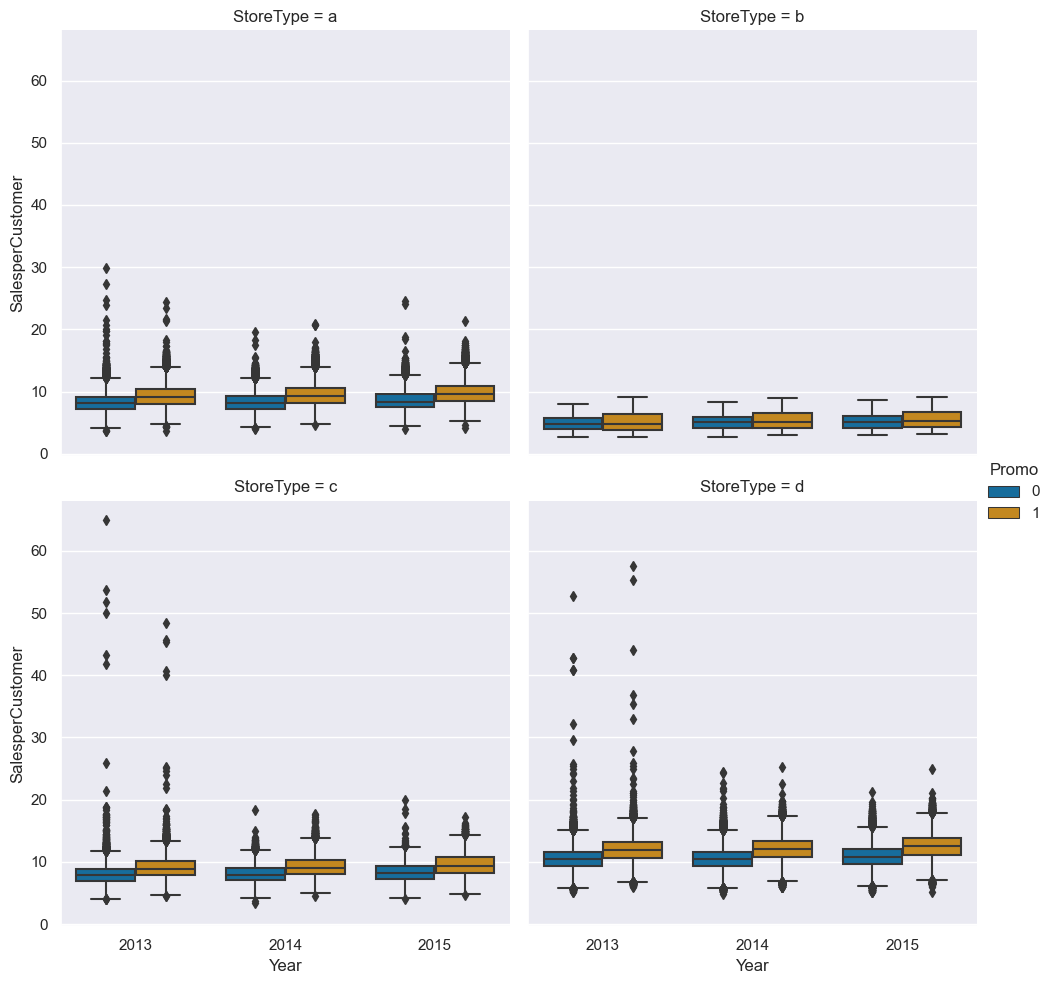

In [43]:
sns.catplot(data=store_open,x='Year',y='SalesperCustomer',col='StoreType',col_order=['a','b','c','d'],
            hue='Promo',palette='colorblind',col_wrap=2, kind='box')
plt.show()

**Compared to other store types, customer behaviour at Store Type `b` is the least sensitive to promotional events.**

In [44]:
store_open.groupby(['StoreType','Promo','Assortment']).SalesperCustomer.describe()

count       mean       std       min  \
StoreType Promo Assortment                                            
a         0     a           157775.0   8.245818  1.465991  3.635389   
                c            94757.0   8.545174  1.533253  4.151235   
          1     a           128253.0   9.355325  1.693864  3.680292   
                c            76257.0   9.606742  1.752278  4.132372   
b         0     a             3963.0   6.004593  0.736876  3.801695   
                b             5077.0   4.168919  0.674202  2.749075   
                c              582.0   5.568012  0.439001  4.289030   
          1     a             2446.0   6.733681  0.780860  4.143487   
                b             3132.0   4.155307  0.545394  2.752415   
                c              360.0   6.079790  0.374720  4.993193   
c         0     a            32268.0   7.739291  1.289794  3.382542   
                c            29967.0   8.489280  1.565809  4.095064   
          1     a            26286.0   8.894304  1.498498  4.448854   
                c            24447.0   9.676534  1.846214  4.686770   
d         0     a            51961.0  10.330576  1.593431  5.583333   
                c            91113.0  10.753989  1.801801  4.881279   
          1     a            41923.0  11.942236  1.838369  6.419786   
                c            73771.0  12.214557  2.020652  5.191489   

                                  25%        50%        75%        max  
StoreType Promo Assortment                                              
a         0     a            7.184426   8.062185   9.121190  29.877551  
                c            7.392801   8.388406   9.570332  24.143521  
          1     a            8.095819   9.141844  10.386454  24.352234  
                c            8.307203   9.445633  10.778080  18.067485  
b         0     a            5.458164   5.962480   6.556883   8.642473  
                b            3.681765   4.061713   4.555769   7.367793  
                c            5.298290   5.521871   5.806864   7.206720  
          1     a            6.152392   6.715897   7.288416   9.203528  
                b            3.776471   4.103035   4.494365   6.942342  
                c            5.812964   6.075476   6.299934   7.722051  
c         0     a            6.832583   7.588140   8.503000  19.916784  
                c            7.376110   8.354905   9.473299  64.957854  
          1     a            7.859049   8.738441   9.793758  21.919866  
                c            8.334942   9.514388  10.906227  48.381148  
d         0     a            9.297175  10.325250  11.389610  52.734737  
                c            9.448370  10.702128  11.930348  24.292722  
          1     a           10.759235  11.959459  13.152529  57.614983  
                c           10.783823  12.180952  13.572871  25.358779

The spending behaviour of customers at Store Type `b` is the least sensitive of all store types to promotional events. In fact, Store Type `b` customers are more likely to visit the stores and leave without buying anything else. For the majority of its customer base, promotional events provide negligible lift to the average spending per person.

Store Type `a` customers show a similar tendency but most will still increase their purchase basket during a promotion. 

Customers at Store Type `c` and `d` are more sensitive to promotional events.

In [45]:
store_open.groupby(['Day','Promo']).Promo.count()

Day        Promo
Friday     0         66481
           1         72152
Monday     0         60315
           1         77242
Saturday   0        144052
Sunday     0          3593
Thursday   0         60510
           1         74116
Tuesday    0         66841
           1         77114
Wednesday  0         65671
           1         76251
Name: Promo, dtype: int64

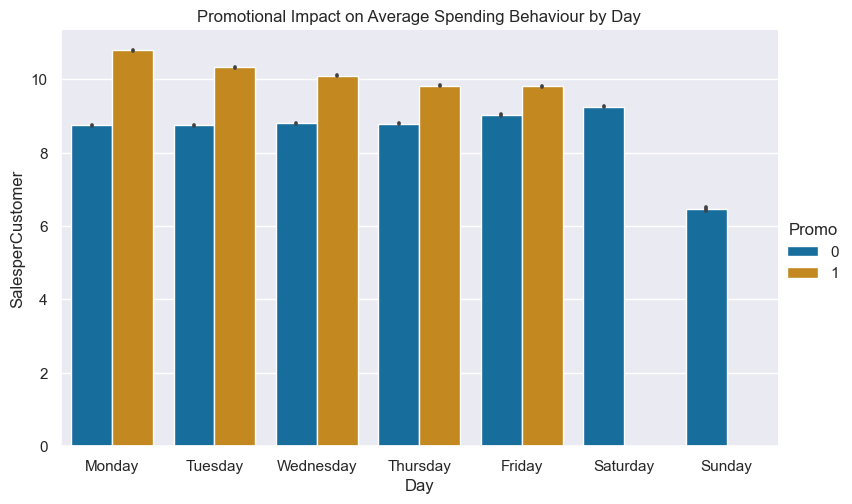

In [46]:
sns.catplot(data=store_open,x='Day',y='SalesperCustomer',hue='Promo',kind='bar',
           height=5,aspect=8/5,palette='colorblind',order=['Monday','Tuesday','Wednesday',
                                                          'Thursday','Friday','Saturday',
                                                          'Sunday'])
plt.title('Promotional Impact on Average Spending Behaviour by Day')
plt.show()

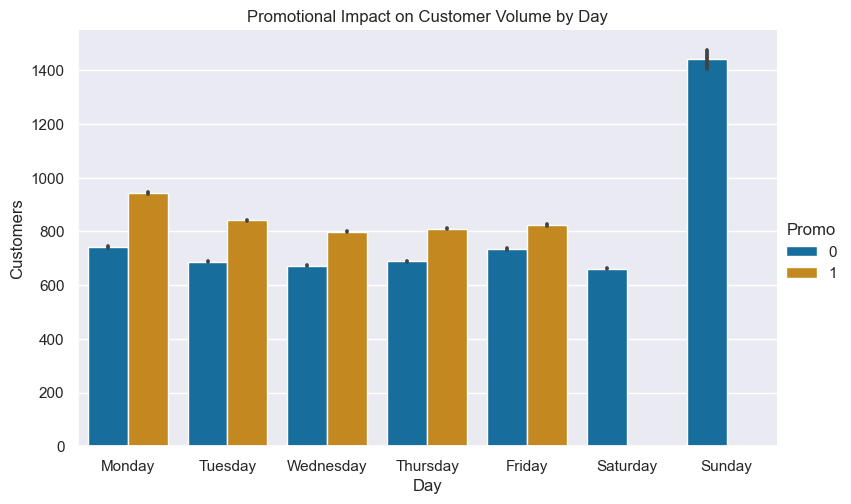

In [47]:
sns.catplot(data=store_open,x='Day',y='Customers',hue='Promo',kind='bar',
           height=5,aspect=8/5,palette='colorblind',order=['Monday','Tuesday',
                                                           'Wednesday','Thursday',
                                                          'Friday','Saturday',
                                                          'Sunday'])
plt.title('Promotional Impact on Customer Volume by Day')
plt.show()

For stores that participate in promotional events, Mondays show the biggest increase in average spending behaviour as well as customer volume. These are weekly events that start on Monday and end on Friday. This is likely because:

- there are no such events over the weekends
- most stores are closed on Sundays 
- advertising for events started over the weekends ?

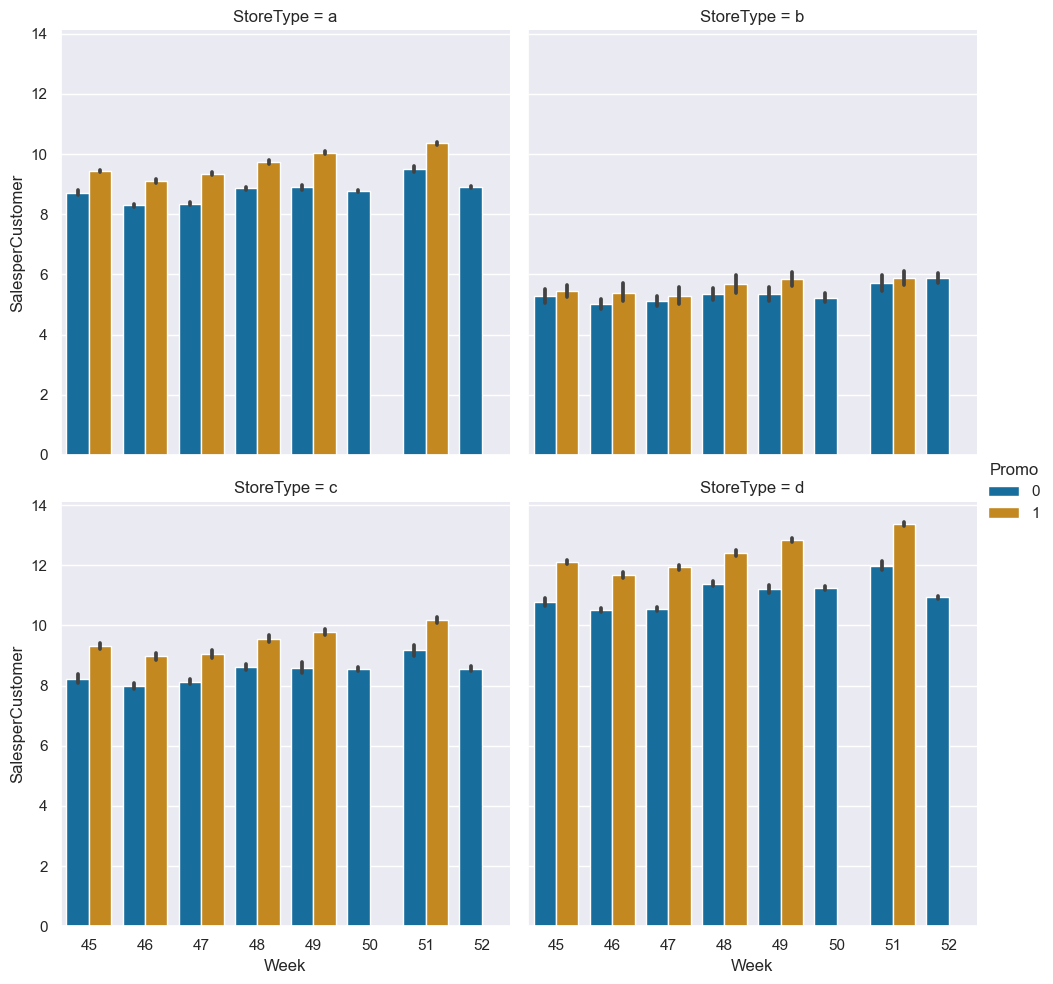

In [48]:
# Christmas week = 44
df=store_open[(store_open.Week>44)]
sns.catplot(data=df,x='Week',y='SalesperCustomer',col='StoreType',col_order=['a','b','c','d'],
            hue='Promo',color='StateHoliday',palette='colorblind', col_wrap=2,kind='bar')
plt.show()

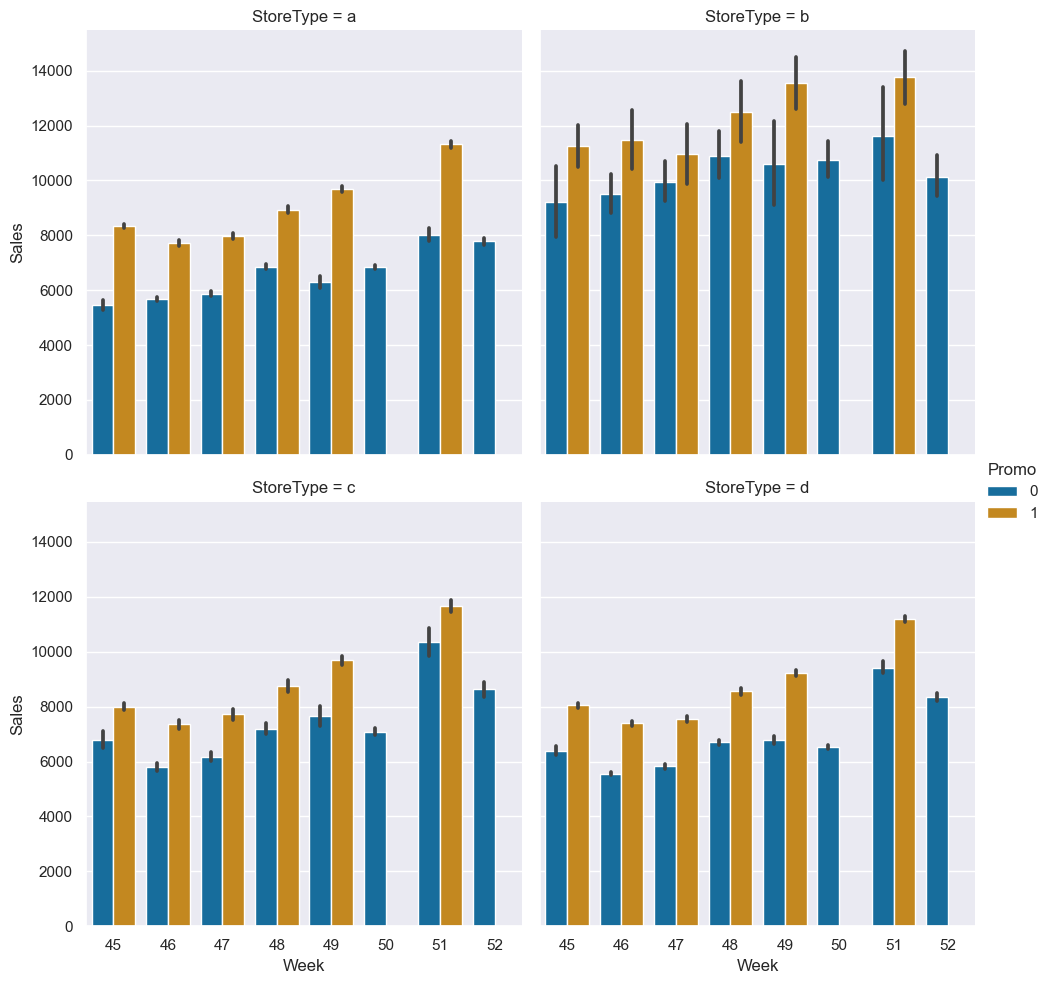

In [49]:
sns.catplot(data=df,x='Week',y='Sales',col='StoreType',col_order=['a','b','c','d'],
            hue='Promo',color='StateHoliday',palette='colorblind',col_wrap=2, kind='bar')
plt.show()

The weeks leading up to Christmas are very important for stores. Even though promotions have little impact on the average individual spending at Store Type `b`, they still provide overall sales lift. Consumers today have come to expect promotions during the weeks before Christmas. Stores with promotions attract higher customer volume than those without.

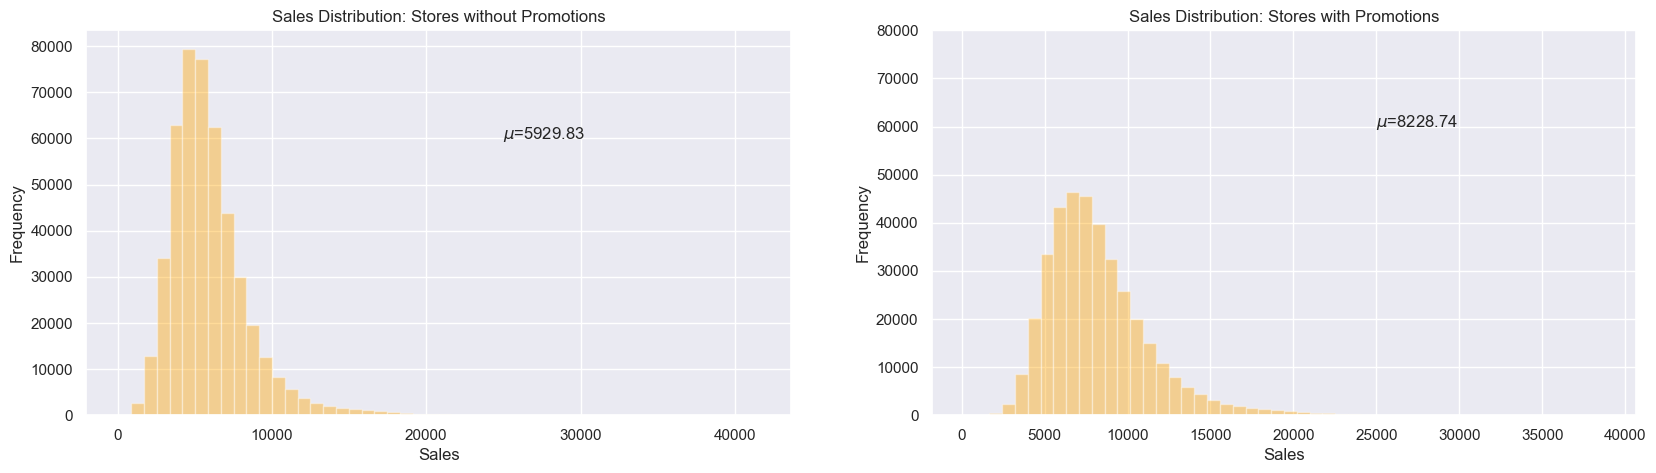

In [50]:
df_promo=store_open[(store_open.Promo==1)]
df_nopromo=store_open[(store_open.Promo==0)]

#Look at the distribution of sales
f,axes=plt.subplots(ncols=2,figsize=(20,5))

sns.distplot(df_nopromo['Sales'],kde=False, color='orange',ax=axes[0])
axes[0].set_ylabel('Frequency')
axes[0].text(25000, 60000, r'$\mu$='+str(round(df_nopromo['Sales'].mean(),2)), 
         fontsize=12)
axes[0].set_title('Sales Distribution: Stores without Promotions')

sns.distplot(df_promo['Sales'],kde=False, color='orange',ax=axes[1])
axes[1].set_ylabel('Frequency')
axes[1].set_ylim([0,80000])
axes[1].text(25000,60000,r'$\mu$='+str(round(df_promo['Sales'].mean(),2)),
             fontsize=12)
axes[1].set_title('Sales Distribution: Stores with Promotions')
plt.show()

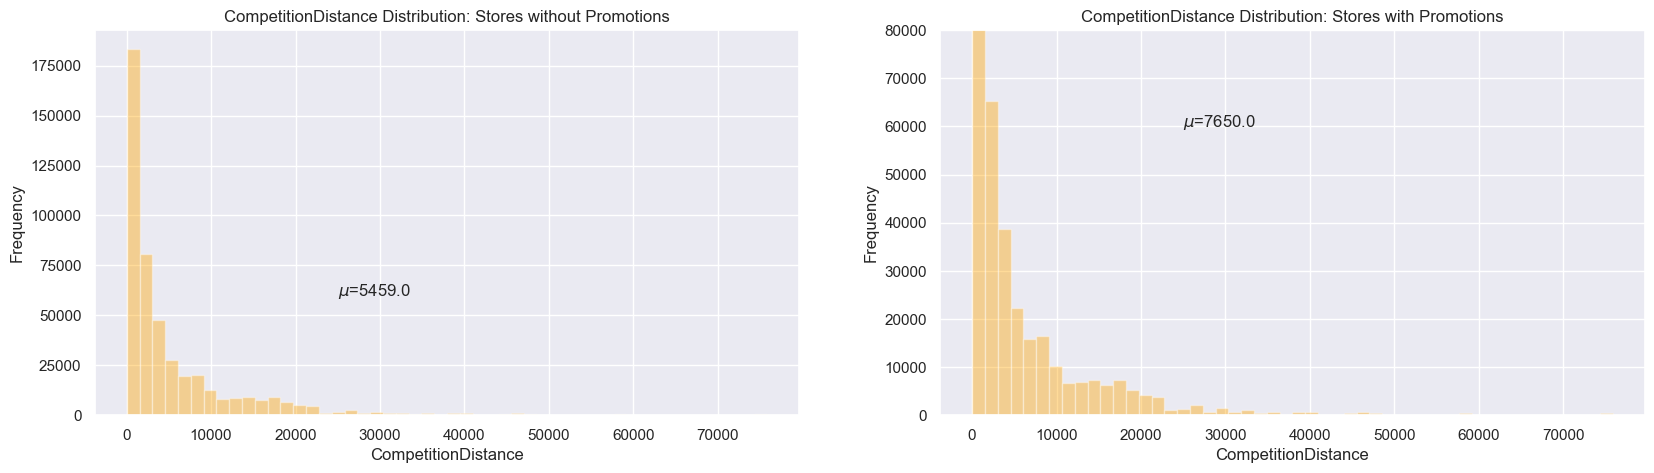

In [51]:
df_promo=store_open[(store_open.Promo==1)]
df_nopromo=store_open[(store_open.Promo==0)]

#Look at the distribution of sales
f,axes=plt.subplots(ncols=2,figsize=(20,5))

sns.distplot(df_nopromo['CompetitionDistance'],kde=False, color='orange',ax=axes[0])
axes[0].set_ylabel('Frequency')
axes[0].text(25000, 60000, r'$\mu$='+str(round(df_nopromo['Sales'].median(),2)), 
         fontsize=12)
axes[0].set_title('CompetitionDistance Distribution: Stores without Promotions')

sns.distplot(df_promo['CompetitionDistance'],kde=False, color='orange',ax=axes[1])
axes[1].set_ylabel('Frequency')
axes[1].set_ylim([0,80000])
axes[1].text(25000,60000,r'$\mu$='+str(round(df_promo['Sales'].median(),2)),
             fontsize=12)
axes[1].set_title('CompetitionDistance Distribution: Stores with Promotions')
plt.show()

#### Promotions Stat Test

It appears that promotions do provide a lift to sales.  Let's test to see if this is really the case and not due to chance market fluctuation.

Sales are not normally distributed but sample size is large.  Consider one-way ANOVA as it is a fairly robust test against normality

In [52]:
#H0: Means are equal (Promotions have no effect)
#H1: Means are not equal (Promotions have effect)

stat,p = f_oneway(df_nopromo.Sales,df_promo.Sales)
print('Statistic= %.3f, p= %.3f'%(stat,p))

#Interpret
alpha=0.05
if p>alpha:
    print('Cannot reject H0, i.e. means are not significantly different')
else:
    print('Reject H0, i.e. means are different.')

Statistic= 132419.435, p= 0.000
Reject H0, i.e. means are different.


**From this point on in this challenge, we will have two dataframe, one with records with promotion and another one without promotions happening.** 

In [53]:
df_promo.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             4   
1      2          5 2015-07-31   6064        625     1      1             4   
2      3          5 2015-07-31   8314        821     1      1             4   
3      4          5 2015-07-31  13995       1498     1      1             4   
4      5          5 2015-07-31   4822        559     1      1             4   

   SchoolHoliday  Week  ...  BeginningOfMonth  StoreType Assortment  \
0              1    31  ...               0.0          c          a   
1              1    31  ...               0.0          a          a   
2              1    31  ...               0.0          a          a   
3              1    31  ...               0.0          c          c   
4              1    31  ...               0.0          a          a   

   CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                        9.0                    2008.0   
1                570.0                       11.0                    2007.0   
2              14130.0                       12.0                    2006.0   
3                620.0                        9.0                    2009.0   
4              29910.0                        4.0                    2015.0   

  Promo2 Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0      0             NaN              NaN              NaN  
1      1            13.0           2010.0  Jan,Apr,Jul,Oct  
2      1            14.0           2011.0  Jan,Apr,Jul,Oct  
3      0             NaN              NaN              NaN  
4      0             NaN              NaN              NaN  

[5 rows x 25 columns]

In [54]:
df_nopromo.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
5565     85          7 2015-07-26  11421       1606     1      0   
5566    122          7 2015-07-26   5773        707     1      0   
5567    209          7 2015-07-26   3742        354     1      0   
5568    259          7 2015-07-26  15998       2857     1      0   
5569    262          7 2015-07-26  32547       4783     1      0   

      StateHoliday  SchoolHoliday  Week  ...  BeginningOfMonth  StoreType  \
5565             4              0    30  ...          0.000677          b   
5566             4              0    30  ...          0.000677          a   
5567             4              0    30  ...          0.000677          a   
5568             4              0    30  ...          0.000677          b   
5569             4              0    30  ...          0.000677          b   

     Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
5565          a               1870.0                       10.0   
5566          c              58260.0                        4.0   
5567          c              11680.0                        9.0   
5568          b                210.0                        NaN   
5569          a               1180.0                        5.0   

      CompetitionOpenSinceYear Promo2 Promo2SinceWeek  Promo2SinceYear  \
5565                    2011.0      0             NaN              NaN   
5566                    2013.0      0             NaN              NaN   
5567                    2011.0      1            31.0           2013.0   
5568                       NaN      0             NaN              NaN   
5569                    2013.0      0             NaN              NaN   

        PromoInterval  
5565              NaN  
5566              NaN  
5567  Jan,Apr,Jul,Oct  
5568              NaN  
5569              NaN  

[5 rows x 25 columns]

In [55]:
X_promo = df_promo.drop(columns=["Sales", "SalesperCustomer", "Customers", "Date"])
y_promo = df_promo[["Sales"]]

X_nopromo = df_nopromo.drop(columns=["Sales", "SalesperCustomer", "Customers", "Date"])
y_nopromo = df_nopromo[["Sales"]]

Correlation between features of `df_promo`:

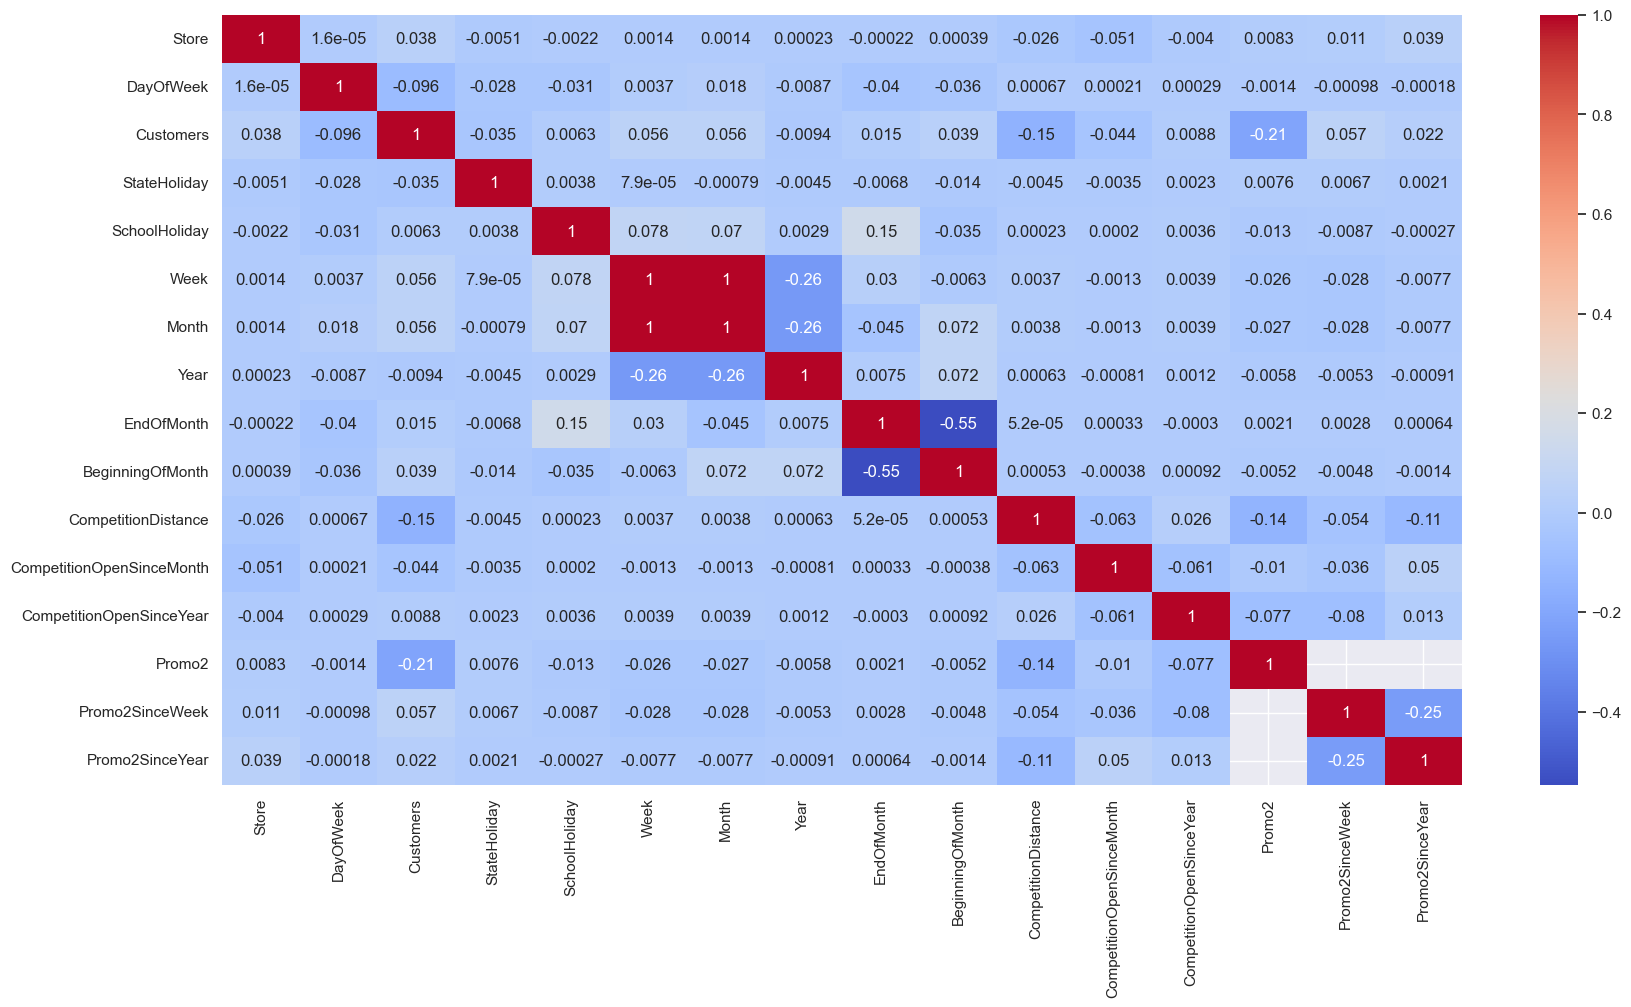

In [56]:
f,axes=plt.subplots(figsize=(20,10))

sns.heatmap(df_promo.drop(columns=["Sales", "SalesperCustomer", "Open", "Promo"]).corr(), 
            annot = True, fmt='.2g',cmap= 'coolwarm')
plt.show()

Correlation between features of `df_nopromo`:

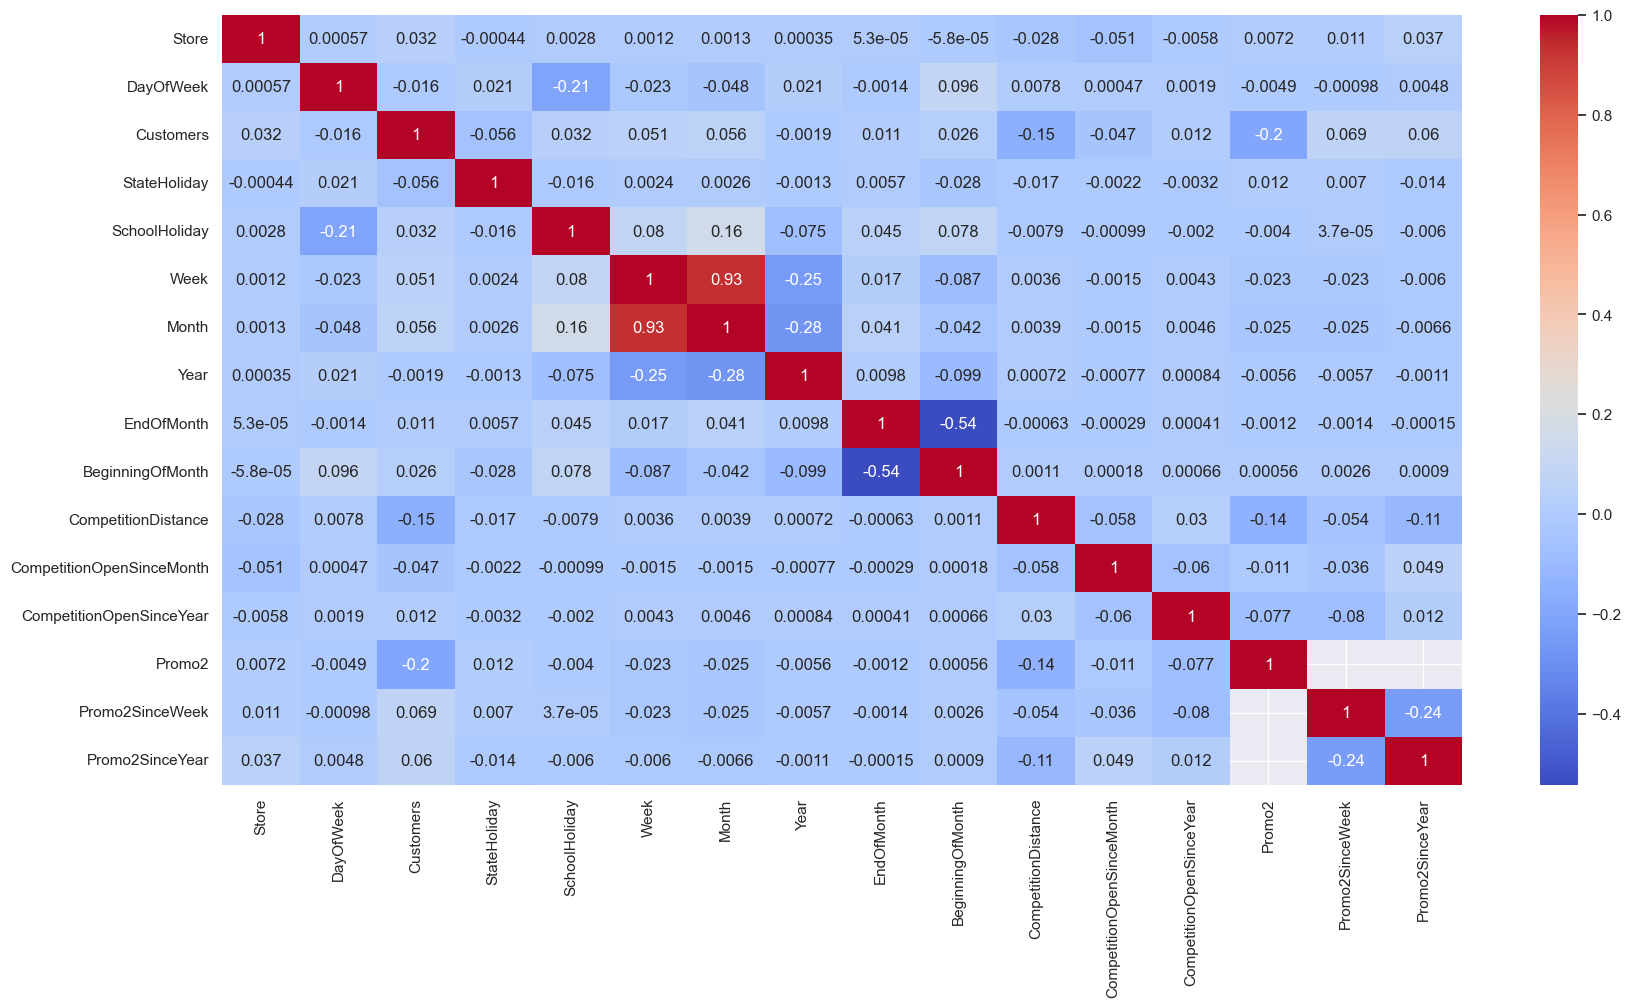

In [57]:
f,axes=plt.subplots(figsize=(20,10))

sns.heatmap(df_nopromo.drop(columns=["Sales", "SalesperCustomer", "Open", "Promo"]).corr(), 
            annot = True, fmt='.2g',cmap= 'coolwarm')
plt.show()

In [58]:
cat_cols = []
target_cols = []
num_cols = []
for c in X_promo.columns:
    col_type = X_promo[c].dtype
    if col_type == "object" or col_type.name == "category":
        X_promo[c] = X_promo[c].astype('category')
        X_nopromo[c] = X_nopromo[c].astype('category')
        cat_cols.append(c)
    elif col_type == "float64" or col_type == "int64":
        num_cols.append(c)

In [59]:
num_cols

['Store',
 'DayOfWeek',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Week',
 'Month',
 'Year',
 'EndOfMonth',
 'BeginningOfMonth',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear']

In [60]:
cat_cols

['Day', 'StoreType', 'Assortment', 'PromoInterval']

#### Data Split:

In [61]:
from sklearn.model_selection import train_test_split

X_train_promo, X_test_promo, y_train_promo, y_test_promo = train_test_split(X_promo, y_promo, test_size=0.30)
X_train_nopromo, X_test_nopromo, y_train_nopromo, y_test_nopromo = train_test_split(X_nopromo, y_nopromo, test_size=0.30)

#### Promo Model - Using LightGBM

In [62]:
model_promo = lgb.LGBMRegressor()
model_promo.fit(X_train_promo, y_train_promo)

expected_y_promo  = y_test_promo
predicted_y_promo = model_promo.predict(X_test_promo)

##### Model Metrics:

In [63]:
from sklearn import metrics
print(metrics.r2_score(expected_y_promo, predicted_y_promo))
print(metrics.mean_squared_log_error(expected_y_promo, predicted_y_promo))
print(metrics.mean_absolute_percentage_error(expected_y_promo, predicted_y_promo)) 
print(metrics.mean_squared_error(expected_y_promo, predicted_y_promo))

0.6876116411532219
0.04739952361802287
0.17816097816380186
3117843.6340220827


##### Feature Importance:

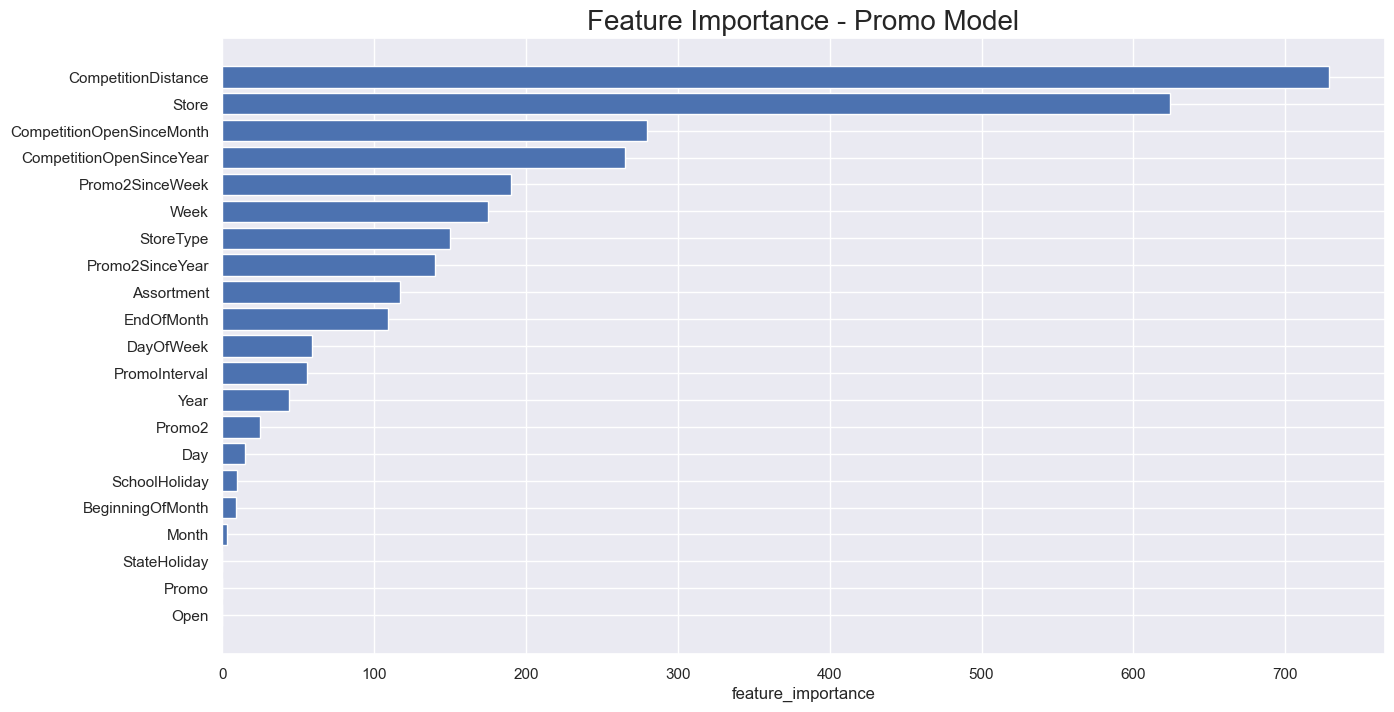

In [187]:
f,axes=plt.subplots(figsize=(15,8))

importances = pd.DataFrame({'feature': X_train_promo.columns, 'importance': model_promo.feature_importances_})
importances = importances.sort_values(by='importance', ascending=True)
plt.barh(y=importances['feature'], width=importances['importance'])
plt.title("Feature Importance - Promo Model", fontsize=20)
plt.xlabel("feature_importance")
plt.show()

##### SHAP:

In [65]:
explainer = shap.TreeExplainer(model_promo)
shap_values = explainer.shap_values(X_train_promo)

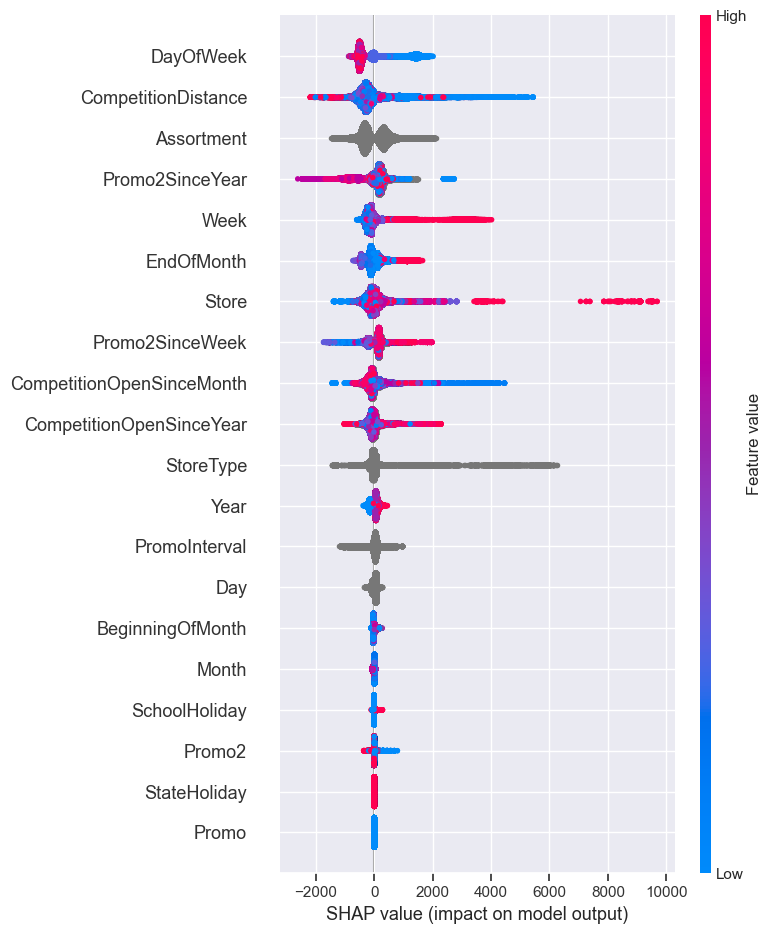

In [73]:
shap.summary_plot(shap_values, X_train_promo)

In [72]:
shap.force_plot(explainer.expected_value, shap_values[4], X_train_promo.iloc[4])

In [68]:
shap.force_plot(explainer.expected_value, shap_values[20001], X_train_promo.iloc[20001])

##### Adding Promo Model results:

In [74]:
promo_results = df_promo.loc[X_test_promo.index]

promo_results["sales"] = expected_y_promo
promo_results["pred_sales"] = predicted_y_promo

In [75]:
promo_results.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
101303     28          1 2015-04-13   7265        748     1      1   
475716    255          1 2014-02-03   9856        889     1      1   
251879    194          1 2014-10-20   5466        475     1      1   
625088    832          1 2013-08-26   9246        687     1      1   
98760     828          4 2015-04-16   6381        676     1      1   

        StateHoliday  SchoolHoliday  Week  ...  Assortment  \
101303             4              0    16  ...           a   
475716             4              0     6  ...           c   
251879             4              0    43  ...           c   
625088             4              0    35  ...           a   
98760              4              0    16  ...           c   

        CompetitionDistance CompetitionOpenSinceMonth  \
101303               1200.0                      10.0   
475716               4630.0                       3.0   
251879              16970.0                       NaN   
625088               5070.0                       NaN   
98760                3290.0                      12.0   

        CompetitionOpenSinceYear  Promo2  Promo2SinceWeek Promo2SinceYear  \
101303                    2014.0       1              6.0          2015.0   
475716                    2011.0       1             35.0          2011.0   
251879                       NaN       1              5.0          2013.0   
625088                       NaN       1             45.0          2009.0   
98760                     2014.0       0              NaN             NaN   

           PromoInterval  sales   pred_sales  
101303  Mar,Jun,Sept,Dec   7265  8084.563253  
475716   Feb,May,Aug,Nov   9856  9117.094266  
251879   Feb,May,Aug,Nov   5466  7708.849301  
625088   Feb,May,Aug,Nov   9246  8841.163716  
98760                NaN   6381  7302.826350  

[5 rows x 27 columns]

##### Residual Analysis:

Text(0.5, 1.0, 'Residual Analysis')

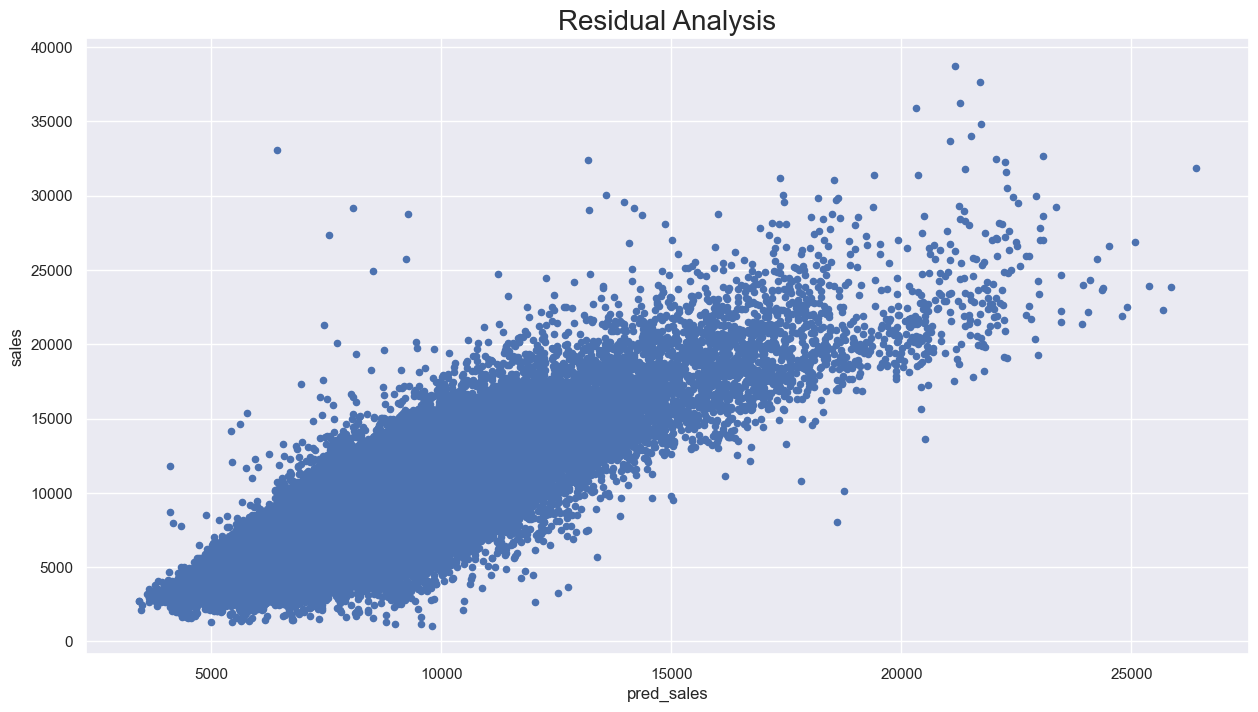

In [189]:
promo_results[["sales", "pred_sales"]].plot(x="pred_sales", y="sales", kind="scatter", figsize=(15, 8))
plt.title("Residual Analysis", fontsize=20)


Text(0.5, 1.0, 'Residual Distribution')

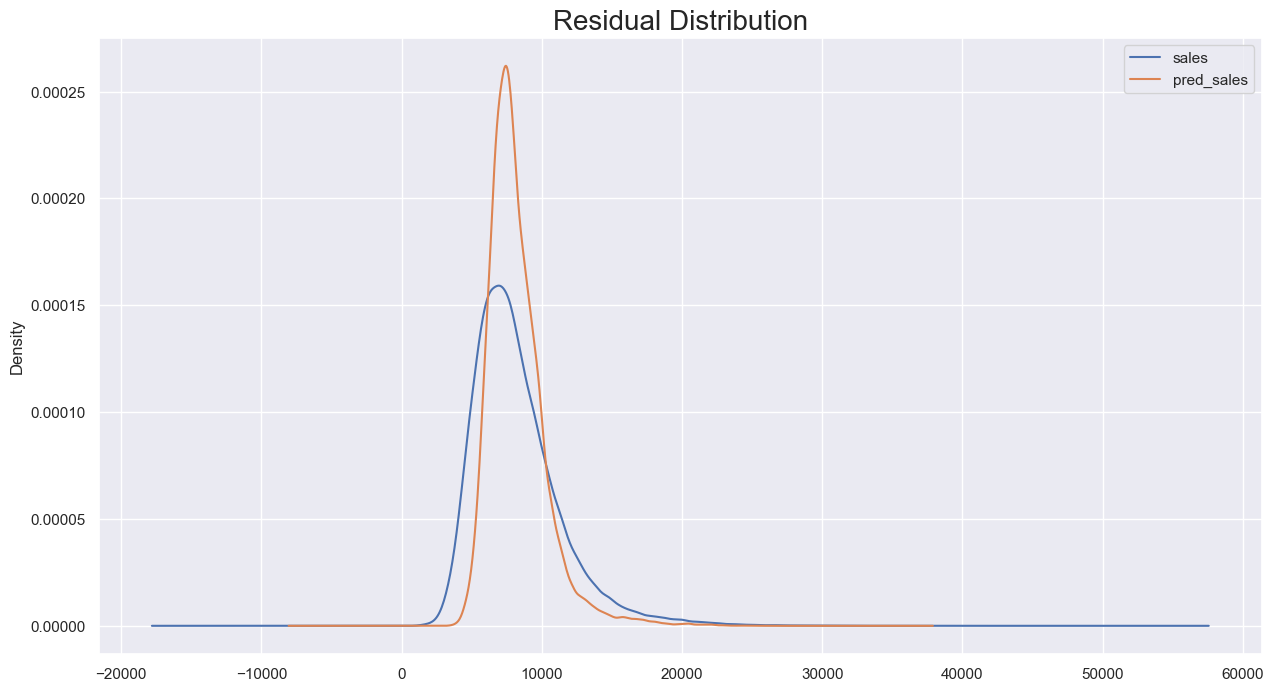

In [190]:
promo_results[["sales", "pred_sales"]].plot(kind="kde", figsize=(15,8))
plt.title("Residual Distribution", fontsize=20)


In [78]:
promo_results[['pred_sales', 'sales', 'Date']].head()

pred_sales  sales       Date
101303  8084.563253   7265 2015-04-13
475716  9117.094266   9856 2014-02-03
251879  7708.849301   5466 2014-10-20
625088  8841.163716   9246 2013-08-26
98760   7302.826350   6381 2015-04-16

In [79]:
def mean_absolute_percentage_error(y_true, y_pred):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [80]:
result_group = promo_results[['pred_sales', 'sales', 'Date']]
result_group = result_group.groupby(by=['Date']).sum().reset_index()

# Calculate the error
result_group['error'] = result_group.apply(lambda x: mean_absolute_percentage_error(x['pred_sales'], x['sales']), axis=1)
result_group.head()

Date    pred_sales    sales     error
0 2013-01-07  3.119740e+06  3139293  0.626752
1 2013-01-08  2.710258e+06  2717170  0.255039
2 2013-01-09  2.186060e+06  2161323  1.131568
3 2013-01-10  2.394021e+06  2336852  2.388000
4 2013-01-11  2.425129e+06  2436771  0.480049

In [81]:
result_group.error.mean()

3.3606122709646122

In [82]:
fig = px.scatter(result_group, x="Date", y="error")
fig.show()

In [83]:
fig = px.line(result_group, x="Date", y="sales")
fig.update_traces(line_color='red')

fig2 = px.line(result_group, x="Date", y="pred_sales")

fig3 = go.Figure(data=fig.data + fig2.data)
fig3.show()

In [84]:
result_store = promo_results[['pred_sales', 'sales', 'Store']]
result_store = result_store.groupby(by='Store').sum().reset_index()

# Calculate the error
result_store['error'] = result_store.apply(lambda x: mean_absolute_percentage_error(x['pred_sales'], x['sales']), axis=1)
result_store.head()

Store    pred_sales    sales      error
0      1  5.929700e+05   458836  22.620704
1      2  8.081427e+05   745721   7.724096
2      3  8.154591e+05   871322   6.850485
3      4  1.110653e+06  1258440  13.306321
4      5  6.090136e+05   628579   3.212630

In [85]:
result_store.shape

(1115, 4)

In [86]:
result_store.error.mean()

13.074154338289304

In [87]:
result_store[result_store.error == result_store.error.min()]

Store     pred_sales   sales     error
234    235  847046.654202  847030  0.001966

In [88]:
result_store.nsmallest(5, ["error"])

Store    pred_sales    sales     error
234     235  8.470467e+05   847030  0.001966
1107   1108  7.265480e+05   726459  0.012254
864     865  9.303278e+05   929954  0.040183
16       17  9.175062e+05   918314  0.088044
178     179  1.013672e+06  1014612  0.092695

In [89]:
result_store.nlargest(5, ["error"])

Store    pred_sales    sales      error
639    640  9.352030e+05  1475998  57.826485
841    842  1.046053e+06  1632347  56.048206
788    789  7.575514e+05   346234  54.295644
424    425  8.283214e+05   396846  52.090335
793    794  7.290048e+05   354152  51.419799

In [90]:
promo_results[(promo_results.Store==1)].shape

(87, 27)

In [91]:
store_id = 280
store_test = promo_results[(promo_results.Store==store_id)].sort_values(by="Date")

In [92]:
fig = px.line(store_test, x="Date", y="sales")
fig.update_traces(line_color='red')

fig2 = px.line(store_test, x="Date", y="pred_sales")

fig3 = go.Figure(data=fig.data + fig2.data)
fig3.show()

#### No Promo Model - Using LightGBM

In [93]:
model_nopromo = lgb.LGBMRegressor()
model_nopromo.fit(X_train_nopromo, y_train_nopromo)

expected_y_nopromo  = y_test_nopromo
predicted_y_nopromo = model_nopromo.predict(X_test_nopromo)

In [94]:
from sklearn import metrics
print(metrics.r2_score(expected_y_nopromo, predicted_y_nopromo))
print(metrics.mean_squared_log_error(expected_y_nopromo, predicted_y_nopromo))
print(metrics.mean_absolute_percentage_error(expected_y_nopromo, predicted_y_nopromo)) 
print(metrics.mean_squared_error(expected_y_nopromo, predicted_y_nopromo))

0.7088553006682463
0.06232414441093414
0.2084143389564173
2006368.7803645069


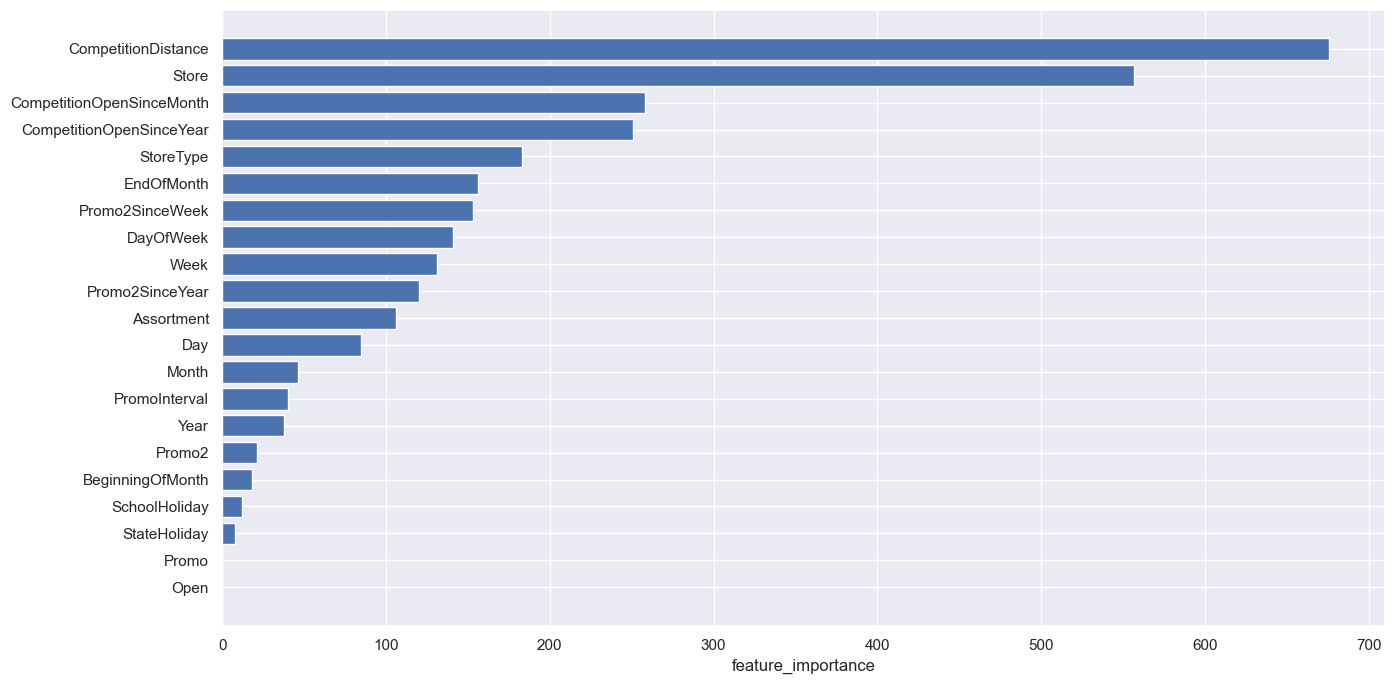

In [95]:
f,axes=plt.subplots(figsize=(15,8))

importances = pd.DataFrame({'feature': X_train_nopromo.columns, 'importance': model_nopromo.feature_importances_})
importances = importances.sort_values(by='importance', ascending=True)
plt.barh(y=importances['feature'], width=importances['importance'])
plt.xlabel("feature_importance")
plt.show()

In [96]:
explainer = shap.TreeExplainer(model_nopromo)
shap_values = explainer.shap_values(X_train_nopromo)

In [97]:
shap.force_plot(explainer.expected_value, shap_values[0], X_train_nopromo.iloc[0])

In [100]:
shap.force_plot(explainer.expected_value, shap_values[30002], X_train_nopromo.iloc[30002])

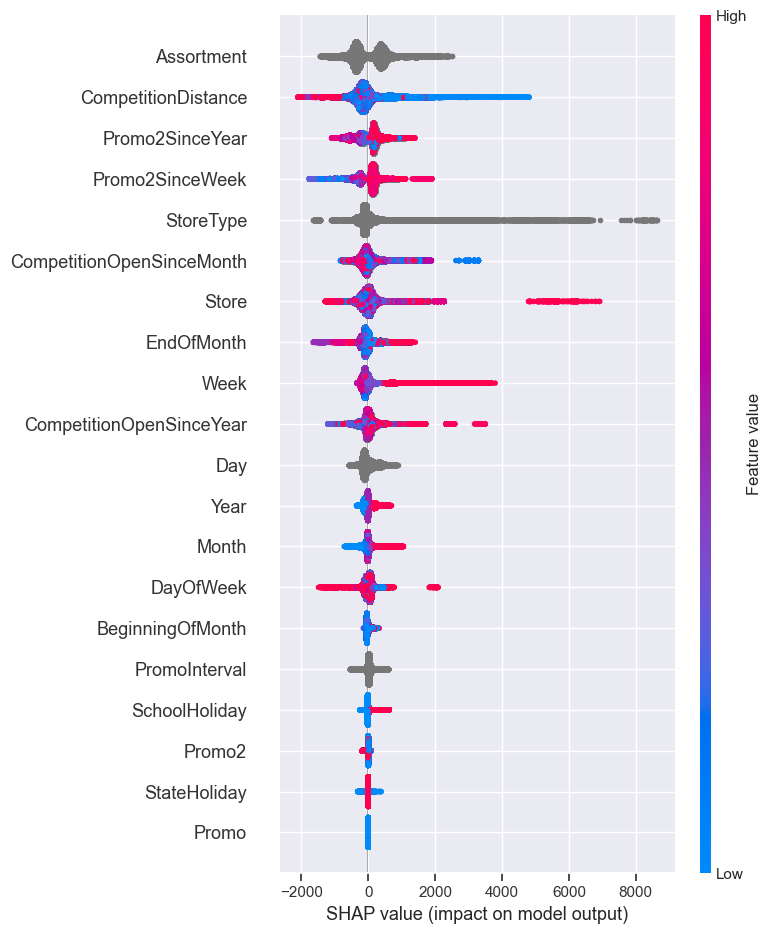

In [101]:
shap.summary_plot(shap_values, X_train_nopromo)

In [102]:
nopromo_results = df_nopromo.loc[X_test_nopromo.index]

nopromo_results["sales"] = expected_y_nopromo
nopromo_results["pred_sales"] = predicted_y_nopromo

In [103]:
nopromo_results.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
495091    686          2 2014-01-14   5406        783     1      0   
385408    528          1 2014-05-12   8432        892     1      0   
682087    954          4 2013-06-27   4837        678     1      0   
392931    186          6 2014-05-03   3726        374     1      0   
573714    940          6 2013-10-19   4430        517     1      0   

        StateHoliday  SchoolHoliday  Week  ...  Assortment  \
495091             4              0     3  ...           a   
385408             4              0    20  ...           c   
682087             4              0    26  ...           a   
392931             4              0    18  ...           a   
573714             4              0    42  ...           c   

        CompetitionDistance CompetitionOpenSinceMonth  \
495091              20050.0                       4.0   
385408              20620.0                       NaN   
682087                390.0                       2.0   
392931                290.0                      10.0   
573714               6470.0                       9.0   

        CompetitionOpenSinceYear  Promo2  Promo2SinceWeek Promo2SinceYear  \
495091                    2002.0       0              NaN             NaN   
385408                       NaN       1             37.0          2009.0   
682087                    2013.0       1             10.0          2014.0   
392931                    2011.0       1             40.0          2014.0   
573714                    2012.0       0              NaN             NaN   

          PromoInterval  sales   pred_sales  
495091              NaN   5406  4852.310150  
385408  Jan,Apr,Jul,Oct   8432  7840.968469  
682087  Jan,Apr,Jul,Oct   4837  5215.112270  
392931  Jan,Apr,Jul,Oct   3726  4461.288518  
573714              NaN   4430  5834.361852  

[5 rows x 27 columns]

<Axes: xlabel='pred_sales', ylabel='sales'>

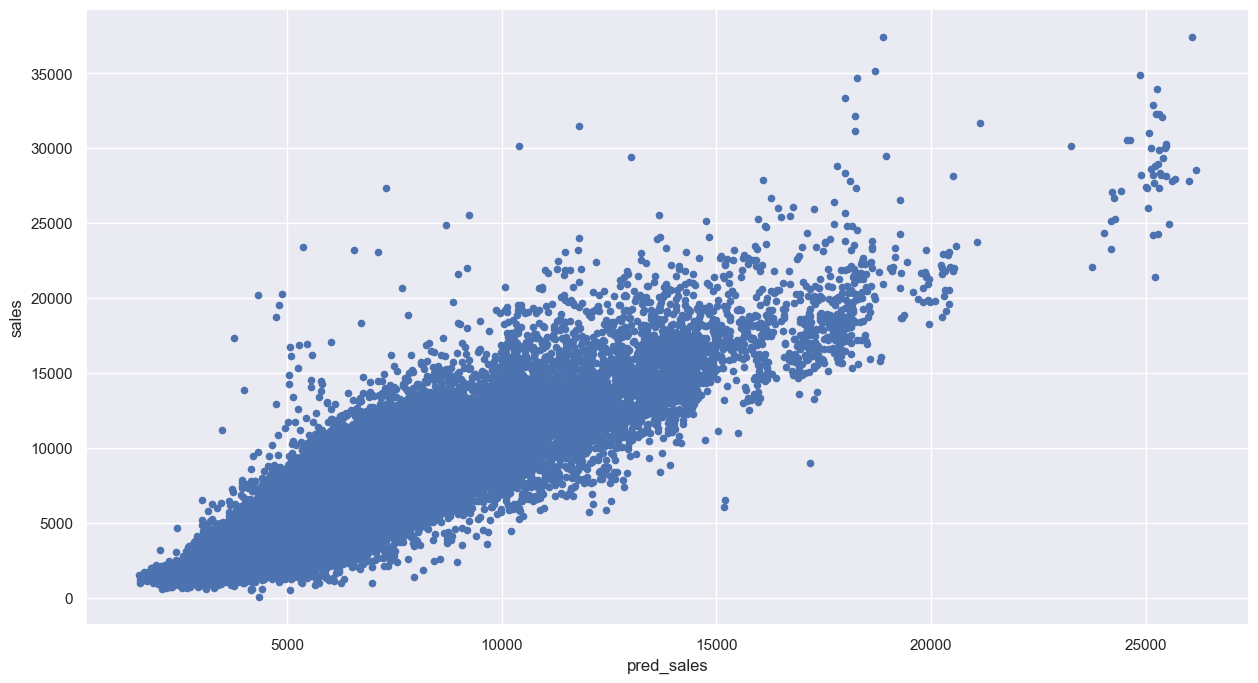

In [104]:
nopromo_results[["sales", "pred_sales"]].plot(x="pred_sales", y="sales", kind="scatter", figsize=(15, 8))

<Axes: ylabel='Density'>

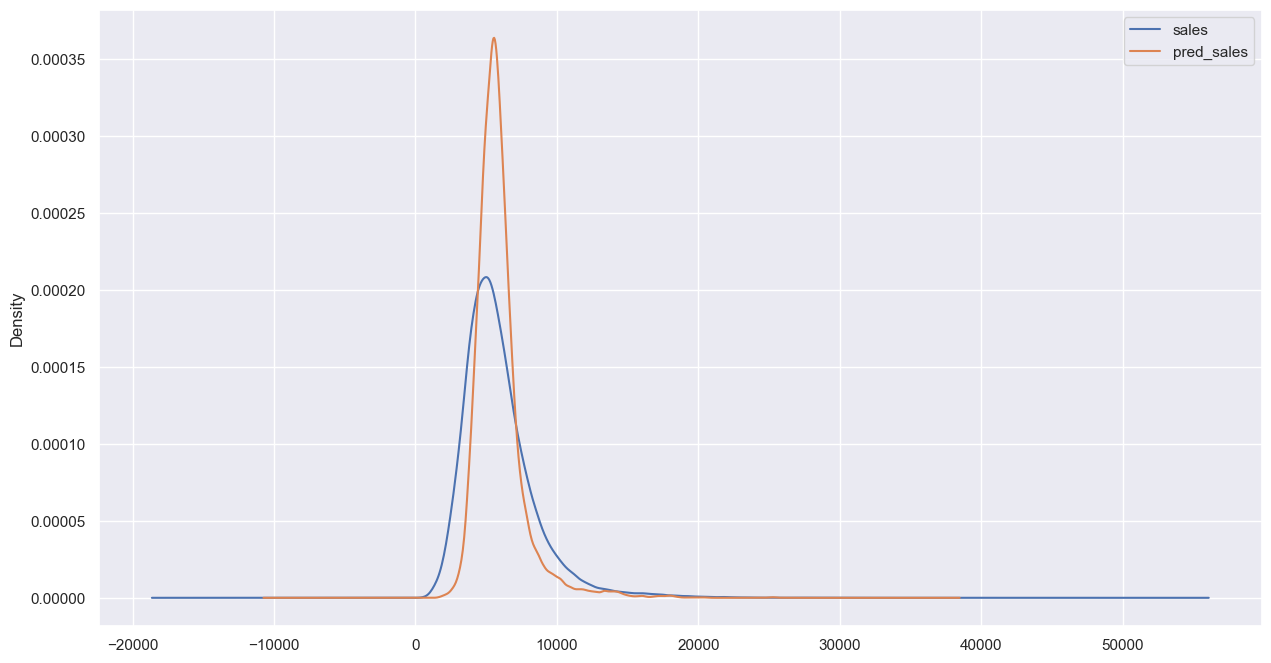

In [105]:
nopromo_results[["sales", "pred_sales"]].plot(kind="kde", figsize=(15, 8))

In [106]:
nopromo_results[['pred_sales', 'sales', 'Date']].head()

pred_sales  sales       Date
495091  4852.310150   5406 2014-01-14
385408  7840.968469   8432 2014-05-12
682087  5215.112270   4837 2013-06-27
392931  4461.288518   3726 2014-05-03
573714  5834.361852   4430 2013-10-19

In [107]:
result_group = nopromo_results[['pred_sales', 'sales', 'Date']]
result_group = result_group.groupby(by=['Date']).sum().reset_index()

# Calculate the error
result_group['error'] = result_group.apply(lambda x: mean_absolute_percentage_error(x['pred_sales'], x['sales']), axis=1)
result_group.head()

Date    pred_sales    sales      error
0 2013-01-01  5.196204e+04    37515  27.803063
1 2013-01-02  2.073006e+06  2173806   4.862479
2 2013-01-03  1.873326e+06  1874748   0.075933
3 2013-01-04  2.076691e+06  2013582   3.038919
4 2013-01-05  1.627781e+06  1541321   5.311551

In [108]:
result_group.error.mean()

5.37255655361648

In [109]:
fig = px.scatter(result_group, x="Date", y="error")
fig.show()

#### Test Performance

In [110]:
fig = px.line(result_group, x="Date", y="sales")
fig.update_traces(line_color='red')

fig2 = px.line(result_group, x="Date", y="pred_sales")

fig3 = go.Figure(data=fig.data + fig2.data)
fig3.show()

In [111]:
result_store = nopromo_results[['pred_sales', 'sales', 'Store']]
result_store = result_store.groupby(by='Store').sum().reset_index()

# Calculate the error
result_store['error'] = result_store.apply(lambda x: mean_absolute_percentage_error(x['pred_sales'], x['sales']), axis=1)
result_store.head()

Store     pred_sales    sales      error
0      1  731762.884437   593183  18.937813
1      2  528620.243633   476506   9.858541
2      3  633600.458872   672795   6.186003
3      4  961836.314497  1203145  25.088332
4      5  450989.435252   468680   3.922612

In [112]:
result_store.shape

(1115, 4)

In [113]:
result_store.error.mean()

13.2409603618571

In [114]:
result_store[result_store.error == result_store.error.min()]

Store     pred_sales   sales     error
368    369  705517.614955  705593  0.010685

In [115]:
result_store.nsmallest(5, ["error"])

Store     pred_sales   sales     error
368    369  705517.614955  705593  0.010685
364    365  469154.380466  469274  0.025497
342    343  780182.937312  779963  0.028190
881    882  880119.888459  880436  0.035917
925    926  762632.236779  762355  0.036353

In [116]:
result_store.nlargest(5, ["error"])

Store    pred_sales    sales      error
841    842  1.332569e+06  2165174  62.481163
767    768  9.336400e+05  1489892  59.578854
542    543  5.629593e+05   237964  57.729804
696    697  7.680364e+05  1188871  54.793571
424    425  7.266417e+05   331009  54.446737

In [117]:
nopromo_results[(nopromo_results.Store==1)].shape

(134, 27)

In [118]:
store_id = 1082
store_test = nopromo_results[(nopromo_results.Store==store_id)].sort_values(by="Date")

In [119]:
fig = px.line(store_test, x="Date", y="sales")
fig.update_traces(line_color='red')

fig2 = px.line(store_test, x="Date", y="pred_sales")

fig3 = go.Figure(data=fig.data + fig2.data)
fig3.show()

#### Hypothesis Test

In [120]:
predicted_y_nopromo.sum()

831567733.8691957

In [121]:
expected_y_nopromo.sum()

Sales    831578845
dtype: int64

In [122]:
predicted_y_promo.sum()

929609794.1230142

In [123]:
expected_y_promo.sum()

Sales    930240775
dtype: int64

#### Notes:

- The nopromo model under predicts a bit
- The promo model under predicts a bit also

### Simulation

Simulating adding promos to all stores without promos

In [124]:
X_test_nopromo_sim = X_test_nopromo.copy()

In [125]:
X_test_nopromo_sim["Promo"] = 1
X_test_nopromo_sim.head()

Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Week  \
495091    686          2     1      1             4              0     3   
385408    528          1     1      1             4              0    20   
682087    954          4     1      1             4              0    26   
392931    186          6     1      1             4              0    18   
573714    940          6     1      1             4              0    42   

        Month  Year       Day  ...  BeginningOfMonth  StoreType Assortment  \
495091      1  2014   Tuesday  ...          0.090438          a          a   
385408      5  2014    Monday  ...          0.141113          a          c   
682087      6  2013  Thursday  ...          0.000277          a          a   
392931      5  2014  Saturday  ...          0.665557          a          a   
573714     10  2013  Saturday  ...          0.022453          d          c   

       CompetitionDistance  CompetitionOpenSinceMonth  \
495091             20050.0                        4.0   
385408             20620.0                        NaN   
682087               390.0                        2.0   
392931               290.0                       10.0   
573714              6470.0                        9.0   

        CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
495091                    2002.0       0              NaN              NaN   
385408                       NaN       1             37.0           2009.0   
682087                    2013.0       1             10.0           2014.0   
392931                    2011.0       1             40.0           2014.0   
573714                    2012.0       0              NaN              NaN   

          PromoInterval  
495091              NaN  
385408  Jan,Apr,Jul,Oct  
682087  Jan,Apr,Jul,Oct  
392931  Jan,Apr,Jul,Oct  
573714              NaN  

[5 rows x 21 columns]

In [126]:
predicted_y_nopromo_sim = model_promo.predict(X_test_nopromo_sim)

In [127]:
predicted_y_nopromo_sim.sum() - predicted_y_nopromo.sum()

286928066.73745275

In [128]:
(predicted_y_nopromo_sim.sum() - predicted_y_nopromo.sum()) / predicted_y_nopromo.sum() * 100

34.50447330398537

If we added promotions for all the samples in our `X_test_nopromo` data (promo == 0) the estimated impact in Sales would be around **~35%**

Let's see the impact at different aggregation levels...

In [129]:
X_test_nopromo_sim["pred_sales"] = predicted_y_nopromo
X_test_nopromo_sim["pred_sales_sim"] = predicted_y_nopromo_sim
X_test_nopromo_sim["sales"] = expected_y_nopromo

In [193]:
X_test_nopromo_sim["uplift"] = X_test_nopromo_sim["pred_sales_sim"] - X_test_nopromo_sim["pred_sales"]
X_test_nopromo_sim["uplift_pct"] = (X_test_nopromo_sim["pred_sales_sim"] - X_test_nopromo_sim["pred_sales"]) / \
                                    X_test_nopromo_sim["pred_sales"] * 100

The uplift in this case is defined as the difference between the sales values with/without sales.

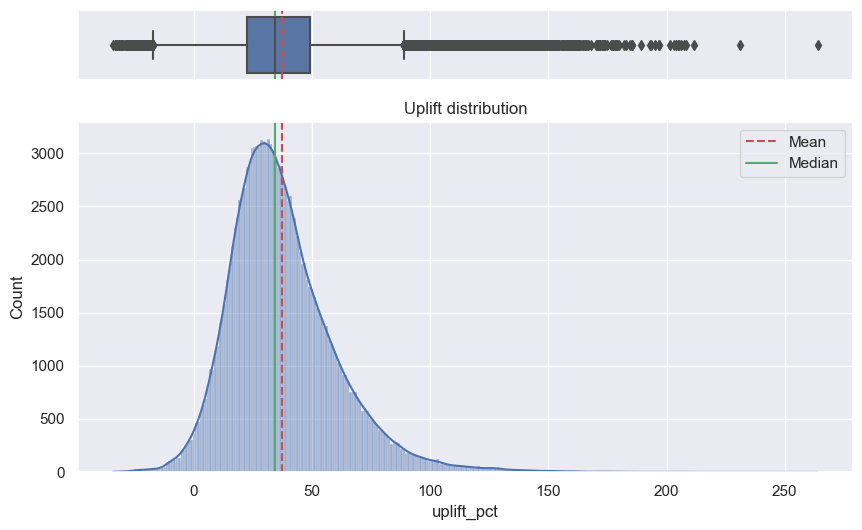

In [194]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)}, figsize=(10,6))
mean = X_test_nopromo_sim["uplift_pct"].mean()
median = X_test_nopromo_sim["uplift_pct"].median()

sns.boxplot(data=X_test_nopromo_sim, x="uplift_pct", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.histplot(data=X_test_nopromo_sim, x="uplift_pct", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")

ax_hist.legend()

ax_box.set(xlabel='')
plt.title("Uplift distribution")
plt.show()

In [197]:
X_test_nopromo_sim["uplift_pct"].quantile([0.01, 0.1, 0.5, 0.90, 0.95, 0.99])

0.01     -4.052360
0.10     13.017090
0.50     34.158482
0.90     66.207781
0.95     78.209972
0.99    108.173370
Name: uplift_pct, dtype: float64

This plot is very informative. 

There is:
- Instances where the uplift is **negative** -- meaning no promos should be made on this circumstances
- The average uplift is around ~34%
- High-value segments, from the 90th percentile up.

### Negative Impact Instances

In [210]:
X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].shape

(2572, 26)

In [209]:
print(f"""This impacts for {round((X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].shape[0] / train_df.shape[0])*100, 3)}% of instances.""")

This impacts for 0.253% of instances.


In [135]:
X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].head()

Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Week  \
200770      9          2     1      1             4              1    52   
579469    262          7     1      1             4              0    41   
5578      494          7     1      1             4              0    30   
83353    1097          7     1      1             4              0    18   
560639    571          6     1      1             4              0    44   

        Month  Year       Day  ...  CompetitionOpenSinceMonth  \
200770     12  2014   Tuesday  ...                        8.0   
579469     10  2013    Sunday  ...                        5.0   
5578        7  2015    Sunday  ...                        6.0   
83353       5  2015    Sunday  ...                        3.0   
560639     11  2013  Saturday  ...                       11.0   

        CompetitionOpenSinceYear Promo2 Promo2SinceWeek  Promo2SinceYear  \
200770                    2000.0      0             NaN              NaN   
579469                    2013.0      0             NaN              NaN   
5578                      2011.0      0             NaN              NaN   
83353                     2002.0      0             NaN              NaN   
560639                    1995.0      1            40.0           2014.0   

          PromoInterval    pred_sales  pred_sales_sim  sales       uplift  
200770              NaN  11650.814189    11441.759946  10636  -209.054243  
579469              NaN  25407.887716    18978.258469  29322 -6429.629247  
5578                NaN   8843.377090     8627.958859   7804  -215.418231  
83353               NaN  10592.512318    10426.841943  13886  -165.670375  
560639  Jan,Apr,Jul,Oct   8033.633075     7902.222684  11455  -131.410390  

[5 rows x 25 columns]

#### Breakdown by `StoreType`

In [216]:
X_test_nopromo_sim.StoreType.value_counts(normalize=True).sort_index()

a    0.538616
b    0.020265
c    0.134734
d    0.306384
Name: StoreType, dtype: float64

In [215]:
X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].StoreType.value_counts(normalize=True).sort_index()

a    0.302877
b    0.227061
c    0.260498
d    0.209565
Name: StoreType, dtype: float64

In [218]:
X_test_nopromo_sim.groupby(["StoreType"]).sales.sum()

StoreType
a    438789922
b     27330101
c    114049882
d    251408940
Name: sales, dtype: int64

In [239]:
X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].groupby(["StoreType"]).sales.sum()

StoreType
a    8032241
b    6475197
c    6743993
d    4615122
Name: sales, dtype: int64

### Predictions - `NoPromo`

In [240]:
X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].groupby(["StoreType"]).pred_sales.sum()

StoreType
a    7.629094e+06
b    5.995449e+06
c    5.899145e+06
d    4.290658e+06
Name: pred_sales, dtype: float64

In [246]:
X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].groupby(["StoreType"]).pred_sales_sim.sum() - \
    X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].groupby(["StoreType"]).pred_sales.sum()

StoreType
a   -441185.521715
b   -722323.009154
c   -415844.678470
d   -192056.827852
dtype: float64

In [245]:
(X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].groupby(["StoreType"]).pred_sales_sim.sum() - \
    X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0].groupby(["StoreType"]).pred_sales.sum()).sum()

-1771410.0371901984

Although the amount of instances can be considered small, the impact on sales its substancial, accounting for almost -2M for this period of testing.

#### Breakdown by `StoreType` and `Assortment`

In [139]:
X_test_nopromo_sim[["StoreType", "Assortment"]].value_counts(normalize=True)

StoreType  Assortment
a          a             0.337046
           c             0.201570
d          c             0.194254
           a             0.112130
c          a             0.069809
           c             0.064925
b          b             0.010632
           a             0.008500
           c             0.001134
dtype: float64

In [140]:
X_test_nopromo_sim[X_test_nopromo_sim["uplift"] < 0][["StoreType", "Assortment"]].value_counts(normalize=True)

StoreType  Assortment
c          a             0.179238
d          c             0.179238
a          c             0.176905
b          b             0.157854
a          a             0.125972
c          c             0.081260
b          a             0.068040
d          a             0.030327
b          c             0.001166
dtype: float64

<Axes: xlabel='Store'>

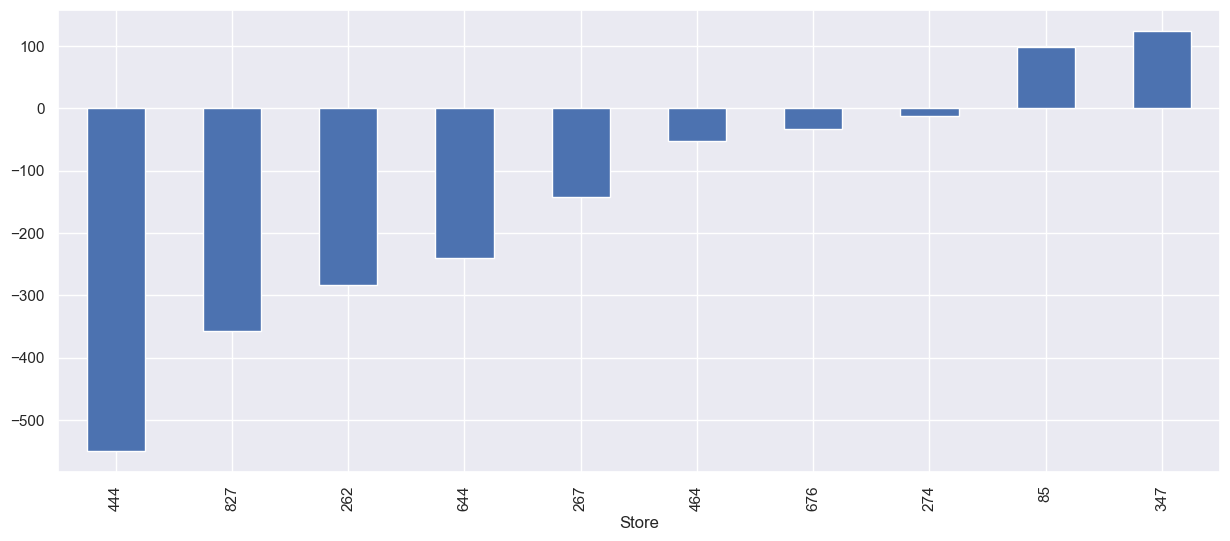

In [141]:
X_test_nopromo_sim.groupby(["Store"]).uplift.mean().sort_values(ascending=True)[:10].plot(kind="bar",figsize=(15, 6))

<Axes: xlabel='Assortment'>

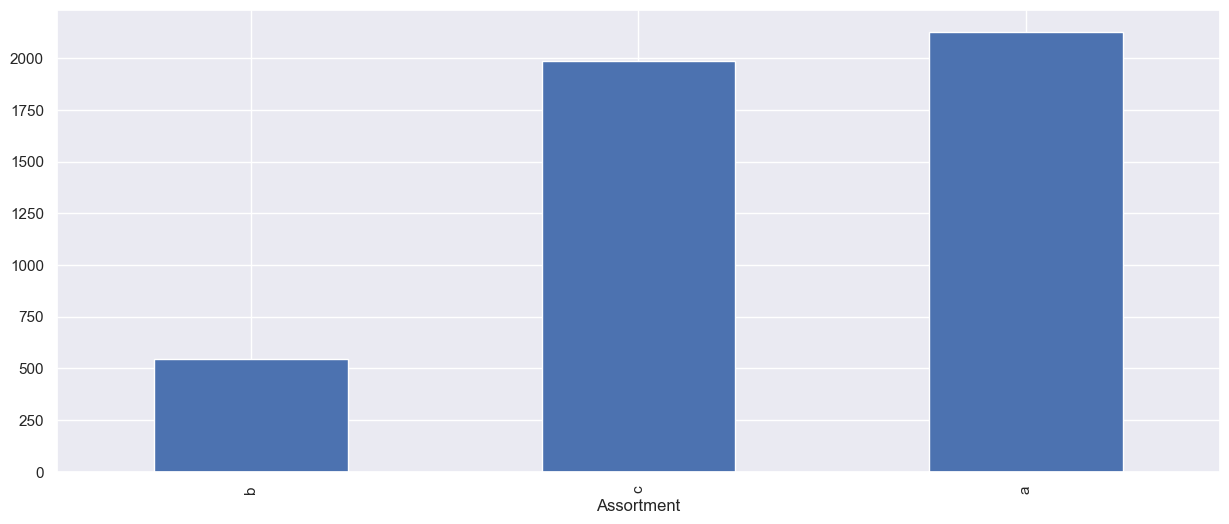

In [142]:
X_test_nopromo_sim.groupby(["Assortment"]).uplift.mean().sort_values(ascending=True).plot(kind="bar",figsize=(15, 6))

In [143]:
X_test_nopromo_sim.groupby(["StoreType", "Assortment"]).uplift.mean()

StoreType  Assortment
a          a             2251.769518
           b                     NaN
           c             2165.160388
b          a             2308.085363
           b              544.292783
           c             2245.205863
c          a             1789.173610
           b                     NaN
           c             1775.465244
d          a             1954.890388
           b                     NaN
           c             1870.159497
Name: uplift, dtype: float64

<Axes: xlabel='StoreType,Assortment'>

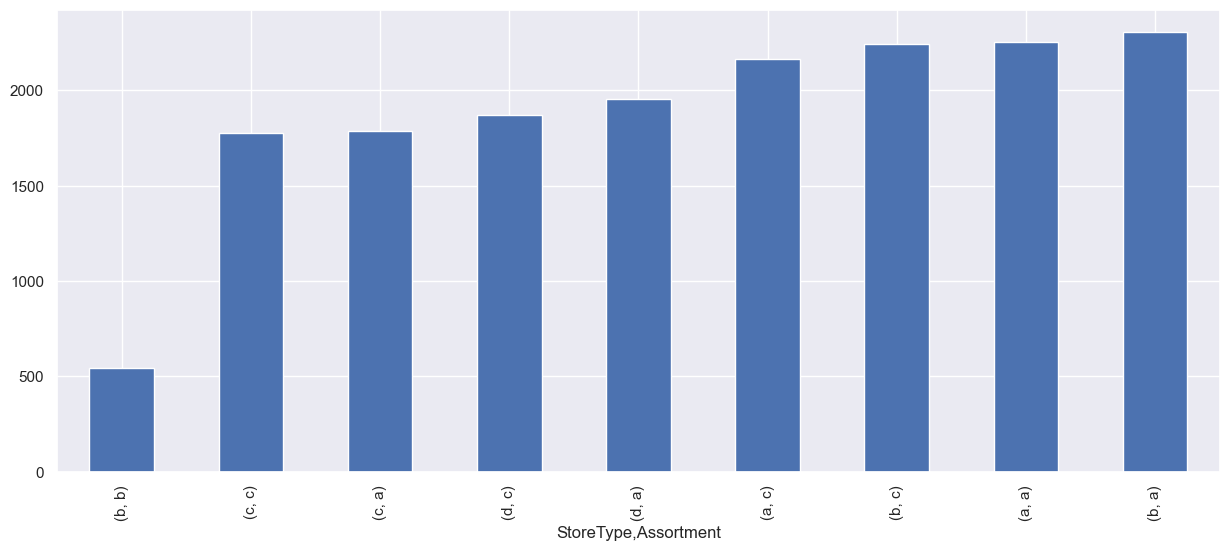

In [144]:
X_test_nopromo_sim.groupby(["StoreType","Assortment"]).uplift.mean().sort_values(ascending=True)[:9].plot(kind="bar",figsize=(15, 6))

As we saw on the EDA, the uplift of using sales for certain combinations of `StoreType` and `Assortment` is lower, meaning that we souldn't do promos for specific combinations:

- Store Type `b` + Assortment `b` - **~600$** increase in the sales of doing/not doing a promotion

<Axes: xlabel='StoreType,Assortment,DayOfWeek'>

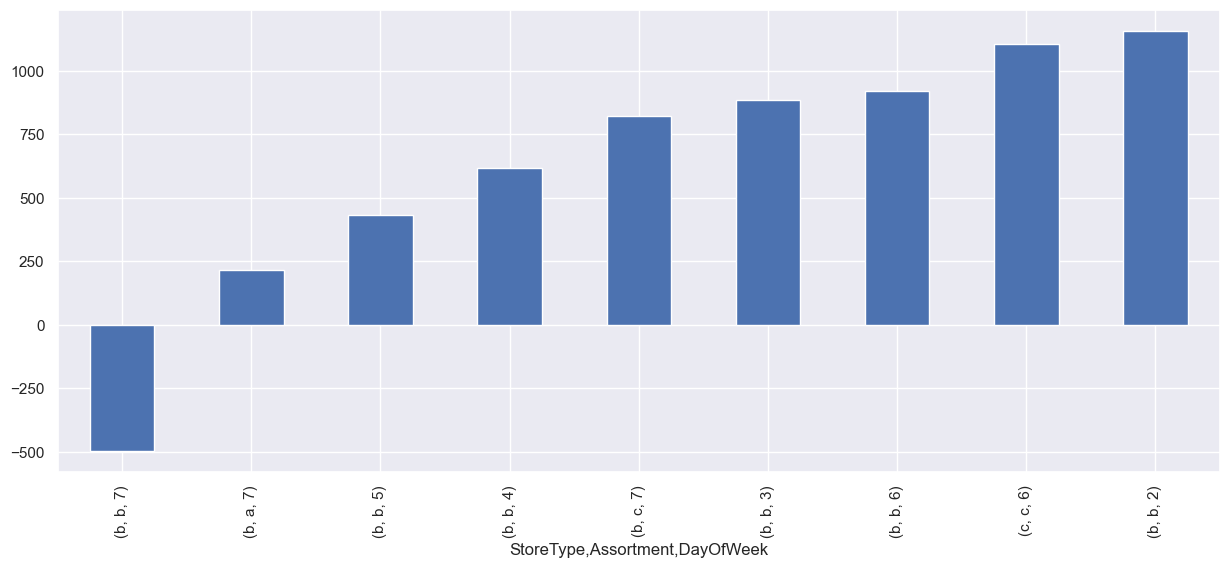

In [145]:
X_test_nopromo_sim.groupby(["StoreType","Assortment", "DayOfWeek"]).uplift.mean().sort_values(ascending=True)[:9].plot(kind="bar",figsize=(15, 6))

### Predict for the Test set

In [146]:
model_nopromo

LGBMRegressor()

In [147]:
model_promo

LGBMRegressor()

In [148]:
test_df = pd.read_csv("./data/test.csv", low_memory=False, parse_dates=["Date"])

In [149]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41077 non-null  float64       
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [150]:
test_df.shape

(41088, 8)

In [151]:
test_df["Week"] = test_df["Date"].dt.week
test_df["Month"] = test_df["Date"].dt.month
test_df['Year']= test_df["Date"].dt.year
test_df['Day']= test_df["Date"].dt.strftime('%A')

In [152]:
test_df['EndOfMonth'] = test_df["Date"].dt.day.apply(get_end_month)
test_df['BeginningOfMonth'] = test_df["Date"].dt.day.apply(get_beginning_month)

In [153]:
test_df["StateHoliday"] = test_df["StateHoliday"].replace(to_replace='0', value='d')
test_df["StateHoliday"].replace({'a':1, 'b':2, 'c':3, 'd':4}, inplace = True)

In [154]:
test_store = pd.merge(left = test_df, right = store_df, how='left', on=['Store'])

In [155]:
test_store.head()

Id  Store  DayOfWeek       Date  Open  Promo  StateHoliday  SchoolHoliday  \
0   1      1          4 2015-09-17   1.0      1             4              0   
1   2      3          4 2015-09-17   1.0      1             4              0   
2   3      7          4 2015-09-17   1.0      1             4              0   
3   4      8          4 2015-09-17   1.0      1             4              0   
4   5      9          4 2015-09-17   1.0      1             4              0   

   Week  Month  ...  BeginningOfMonth StoreType  Assortment  \
0    38      9  ...          0.041597         c           a   
1    38      9  ...          0.041597         a           a   
2    38      9  ...          0.041597         a           c   
3    38      9  ...          0.041597         a           a   
4    38      9  ...          0.041597         a           c   

   CompetitionDistance CompetitionOpenSinceMonth CompetitionOpenSinceYear  \
0               1270.0                       9.0                   2008.0   
1              14130.0                      12.0                   2006.0   
2              24000.0                       4.0                   2013.0   
3               7520.0                      10.0                   2014.0   
4               2030.0                       8.0                   2000.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0       0              NaN              NaN              NaN  
1       1             14.0           2011.0  Jan,Apr,Jul,Oct  
2       0              NaN              NaN              NaN  
3       0              NaN              NaN              NaN  
4       0              NaN              NaN              NaN  

[5 rows x 23 columns]

In [156]:
test_promo = test_store[(test_store.Promo==1)]
test_promo_id = test_store[(test_store.Promo==1)].Id

test_nopromo=test_store[(test_store.Promo==0)]
test_nopromo_id = test_store[(test_store.Promo==0)].Id

In [157]:
test_promo.shape

(16264, 23)

In [158]:
test_nopromo.shape

(24824, 23)

In [159]:
X_test_promo = test_promo.drop(columns=["Id", "Date"])
X_test_nopromo = test_nopromo.drop(columns=["Id", "Date"])

In [160]:
X_test_promo.head()

Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Week  Month  \
0      1          4   1.0      1             4              0    38      9   
1      3          4   1.0      1             4              0    38      9   
2      7          4   1.0      1             4              0    38      9   
3      8          4   1.0      1             4              0    38      9   
4      9          4   1.0      1             4              0    38      9   

   Year       Day  ...  BeginningOfMonth  StoreType Assortment  \
0  2015  Thursday  ...          0.041597          c          a   
1  2015  Thursday  ...          0.041597          a          a   
2  2015  Thursday  ...          0.041597          a          c   
3  2015  Thursday  ...          0.041597          a          a   
4  2015  Thursday  ...          0.041597          a          c   

  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0              1270.0                        9.0                    2008.0   
1             14130.0                       12.0                    2006.0   
2             24000.0                        4.0                    2013.0   
3              7520.0                       10.0                    2014.0   
4              2030.0                        8.0                    2000.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0       0              NaN              NaN              NaN  
1       1             14.0           2011.0  Jan,Apr,Jul,Oct  
2       0              NaN              NaN              NaN  
3       0              NaN              NaN              NaN  
4       0              NaN              NaN              NaN  

[5 rows x 21 columns]

In [161]:
X_train_promo.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'Week', 'Month', 'Year', 'Day', 'EndOfMonth', 'BeginningOfMonth',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [162]:
X_test_promo.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'Week', 'Month', 'Year', 'Day', 'EndOfMonth', 'BeginningOfMonth',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [163]:
cat_cols = []
target_cols = []
num_cols = []
for c in X_test_promo.columns:
    col_type = X_test_promo[c].dtype
    if col_type == "object" or col_type.name == "category":
        X_test_promo[c] = X_test_promo[c].astype('category')
        X_test_nopromo[c] = X_test_nopromo[c].astype('category')
        cat_cols.append(c)
    elif col_type == "float64" or col_type == "int64":
        num_cols.append(c)

In [164]:
cat_cols

['Day', 'StoreType', 'Assortment', 'PromoInterval']

In [165]:
X_test_promo_pred = model_promo.predict(X_test_promo)
X_test_nopromo_pred = model_nopromo.predict(X_test_nopromo)

In [166]:
X_test_promo.head()

Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Week  Month  \
0      1          4   1.0      1             4              0    38      9   
1      3          4   1.0      1             4              0    38      9   
2      7          4   1.0      1             4              0    38      9   
3      8          4   1.0      1             4              0    38      9   
4      9          4   1.0      1             4              0    38      9   

   Year       Day  ...  BeginningOfMonth  StoreType Assortment  \
0  2015  Thursday  ...          0.041597          c          a   
1  2015  Thursday  ...          0.041597          a          a   
2  2015  Thursday  ...          0.041597          a          c   
3  2015  Thursday  ...          0.041597          a          a   
4  2015  Thursday  ...          0.041597          a          c   

  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0              1270.0                        9.0                    2008.0   
1             14130.0                       12.0                    2006.0   
2             24000.0                        4.0                    2013.0   
3              7520.0                       10.0                    2014.0   
4              2030.0                        8.0                    2000.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0       0              NaN              NaN              NaN  
1       1             14.0           2011.0  Jan,Apr,Jul,Oct  
2       0              NaN              NaN              NaN  
3       0              NaN              NaN              NaN  
4       0              NaN              NaN              NaN  

[5 rows x 21 columns]

In [167]:
test_df_promo = test_df[test_df.Id.isin(test_promo_id)]
test_df_nopromo = test_df[test_df.Id.isin(test_nopromo_id)]

In [168]:
test_df_promo["Sales"] = X_test_promo_pred
test_df_nopromo["Sales"] = X_test_nopromo_pred

In [169]:
test_df_promo[test_df_promo.Open == 0].Sales

543      5475.857951
676      6058.055330
840      9447.138195
1399     5484.399557
1532     6066.596937
1696     9455.679802
2255     6260.658150
2388     6455.032519
2552     9806.222413
3111     7853.953403
3244     8028.577168
3408    10284.887408
Name: Sales, dtype: float64

In [170]:
test_df_promo.loc[test_df_promo.Open == 0, 'Sales'] = 0
test_df_nopromo.loc[test_df_nopromo.Open == 0, 'Sales'] = 0

In [171]:
test_df_promo[test_df_promo.Open == 0].Sales

543     0.0
676     0.0
840     0.0
1399    0.0
1532    0.0
1696    0.0
2255    0.0
2388    0.0
2552    0.0
3111    0.0
3244    0.0
3408    0.0
Name: Sales, dtype: float64

In [172]:
final_test_df = test_df_promo.append(test_df_nopromo)

In [173]:
final_test_df.head()

Id  Store  DayOfWeek       Date  Open  Promo  StateHoliday  SchoolHoliday  \
0   1      1          4 2015-09-17   1.0      1             4              0   
1   2      3          4 2015-09-17   1.0      1             4              0   
2   3      7          4 2015-09-17   1.0      1             4              0   
3   4      8          4 2015-09-17   1.0      1             4              0   
4   5      9          4 2015-09-17   1.0      1             4              0   

   Week  Month  Year       Day  EndOfMonth  BeginningOfMonth        Sales  
0    38      9  2015  Thursday    0.090438          0.041597  5671.167916  
1    38      9  2015  Thursday    0.090438          0.041597  7310.765211  
2    38      9  2015  Thursday    0.090438          0.041597  8839.290595  
3    38      9  2015  Thursday    0.090438          0.041597  6386.332031  
4    38      9  2015  Thursday    0.090438          0.041597  7874.407688

In [174]:
final_test_df = final_test_df.drop(columns= ["Week", "Month", "Year", "Day", "EndOfMonth", "BeginningOfMonth"])

In [175]:
final_test_df.head()

Id  Store  DayOfWeek       Date  Open  Promo  StateHoliday  SchoolHoliday  \
0   1      1          4 2015-09-17   1.0      1             4              0   
1   2      3          4 2015-09-17   1.0      1             4              0   
2   3      7          4 2015-09-17   1.0      1             4              0   
3   4      8          4 2015-09-17   1.0      1             4              0   
4   5      9          4 2015-09-17   1.0      1             4              0   

         Sales  
0  5671.167916  
1  7310.765211  
2  8839.290595  
3  6386.332031  
4  7874.407688

In [176]:
final_test_df.tail()

Id  Store  DayOfWeek       Date  Open  Promo  StateHoliday  \
41083  41084   1111          6 2015-08-01   1.0      0             4   
41084  41085   1112          6 2015-08-01   1.0      0             4   
41085  41086   1113          6 2015-08-01   1.0      0             4   
41086  41087   1114          6 2015-08-01   1.0      0             4   
41087  41088   1115          6 2015-08-01   1.0      0             4   

       SchoolHoliday         Sales  
41083              0   4246.681782  
41084              0   8341.433903  
41085              0   6691.501856  
41086              0  19388.804654  
41087              1   5630.796649

In [177]:
final_test_df.to_csv("./data/predictions.csv", index=False)

In [178]:
fig = px.line(train_df[train_df.Store == 1111], x="Date", y="Sales")
fig.update_traces(line_color='red')

fig2 = px.line(final_test_df[final_test_df.Store == 1111].sort_values("Date"), x="Date", y="Sales")
fig2.update_traces(line_color='blue')

fig3 = go.Figure(data=fig.data + fig2.data)
fig3.show()

In [179]:
fig = px.line(train_df[train_df.Store == 1], x="Date", y="Sales")
fig.update_traces(line_color='red')

fig2 = px.line(final_test_df[final_test_df.Store == 1].sort_values("Date"), x="Date", y="Sales")
fig2.update_traces(line_color='blue')

fig3 = go.Figure(data=fig.data + fig2.data)
fig3.show()

### Notes:

- If had more time would have explored the results a bit better
- Would have made the optimization engine
- Would have more time in feature engineering
- Would have explore the econml package from microsoft
- Would have done a more comprehensive and in depth exploration of causality models